In [1]:
# Importaciones
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from geopy import distance

In [2]:
# sv: archivos con los puntos de medida
# 
# Diccionarios
dicc_IdCod = {} # Dado el ID entrega el código
dicc_IdLatLon = {} # Dado el ID entrega [latitud,longitud]
dicc_posID = {} # Dado el ID entrega la posición en las grillas
dicc_ID_mV = {} # Diccionario con el número de muestras de <velocidad> por sensor

# Listas
lista_Ids = [] # IDs de los sensores en el mes de enero (fuente de datos que cumple con el 5% máximo de pérdida)
lista_Fechas = [] # Fechas que hay con muestras en el archivo de datos.


In [3]:
sv = pd.read_csv('pmed_2024/pmed_ubicacion_01-2024.csv', sep=';', quotechar='"')
pmed_encabezados = ["tipo_elem","distrito","id","cod_cent","nombre","utm_x","utm_y","longitud","latitud"]


In [4]:
sufijo_archivos_datos = ["01-2024.csv", "02-2024.csv", "03-2024.csv", "04-2024.csv", "05-2024.csv", "06-2024.csv", "07-2024.csv", "08-2024.csv", "09-2024.csv", "10-2024.csv", "11-2024.csv", "12-2024.csv"]
sensorXmes = []
for sad in sufijo_archivos_datos:
    archivo = 'pmed_2024/pmed_ubicacion_' + sad
    df = pd.read_csv(archivo, sep=';', quotechar='"', encoding='latin-1')
    print(archivo, df.shape)
    filas = df.shape[0]
    conteosensores = 0
    for v in range(filas):
        data_id = df["id"][v]
        data_cod = df["cod_cent"][v]
        data_latlon = [df["longitud"][v],df["latitud"][v]]
        if data_cod[:2] == "PM":
            if data_id not in dicc_IdCod:
                dicc_IdCod[data_id] = data_cod
                dicc_IdLatLon[data_id] = [data_latlon]
                conteosensores += 1
                pr = sad + "\t" + str(data_id) + "\t" + str(data_cod) + "\t" + str(data_latlon[0])[:10] + "\t" + str(data_latlon[1])[:10] + "\t" + str(type(data_latlon[0]))
                print(pr)
    sensorXmes.append(conteosensores)

pmed_2024/pmed_ubicacion_01-2024.csv (4910, 9)
01-2024.csv	6640	PM10013	-3.6741153	40.4810095	<class 'numpy.float64'>
01-2024.csv	6641	PM10021	-3.6740765	40.4806959	<class 'numpy.float64'>
01-2024.csv	6642	PM10091	-3.6743945	40.4760379	<class 'numpy.float64'>
01-2024.csv	6643	PM10092	-3.6745793	40.4759797	<class 'numpy.float64'>
01-2024.csv	6644	PM10141	-3.6717572	40.4708744	<class 'numpy.float64'>
01-2024.csv	6645	PM10142	-3.6718426	40.4708340	<class 'numpy.float64'>
01-2024.csv	6646	PM10211	-3.6684298	40.4664557	<class 'numpy.float64'>
01-2024.csv	6647	PM10212	-3.6686381	40.4664143	<class 'numpy.float64'>
01-2024.csv	6648	PM10241	-3.6667503	40.4633612	<class 'numpy.float64'>
01-2024.csv	6649	PM10242	-3.6669821	40.4633238	<class 'numpy.float64'>
01-2024.csv	10297	PM10293	-3.6653767	40.4601917	<class 'numpy.float64'>
01-2024.csv	6650	PM10341	-3.6634205	40.4545233	<class 'numpy.float64'>
01-2024.csv	6651	PM10342	-3.6637176	40.4544163	<class 'numpy.float64'>
01-2024.csv	6652	PM10343	-3.6

In [5]:
# Reportando cantidad de sensores que agrega cada mes
for i in range(len(sufijo_archivos_datos)):
    print(sufijo_archivos_datos[i], sensorXmes[i], "sensores agregados.")

01-2024.csv 296 sensores agregados.
02-2024.csv 0 sensores agregados.
03-2024.csv 0 sensores agregados.
04-2024.csv 0 sensores agregados.
05-2024.csv 0 sensores agregados.
06-2024.csv 0 sensores agregados.
07-2024.csv 0 sensores agregados.
08-2024.csv 0 sensores agregados.
09-2024.csv 0 sensores agregados.
10-2024.csv 0 sensores agregados.
11-2024.csv 15 sensores agregados.
12-2024.csv 10 sensores agregados.


In [6]:
# Sólo se mantienen los sensores de enero para trabajar
# Los demás meses no agregan sensores nuevos y los datos
# de noviembre y diciembre no cumplen el 5% mínimo

# Reiniciando Diccionarios
dicc_IdCod = {}
dicc_IdLatLon = {}
# Procesando los datos de ENERO
archivo = 'pmed_2024/pmed_ubicacion_01-2024.csv'
df = pd.read_csv(archivo, sep=';', quotechar='"', encoding='latin-1')
filas = df.shape[0]
for v in range(filas):
    data_id = df["id"][v]
    data_cod = df["cod_cent"][v]
    data_latlon = [df["longitud"][v],df["latitud"][v]]
    if data_cod[:2] == "PM":
        if data_id not in dicc_IdCod:
            dicc_IdCod[data_id] = data_cod
            dicc_IdLatLon[data_id] = [data_latlon]

In [7]:
# Exportando los Ids de los sensores registrados para proceso de filtrado de las fuentes de datos (C++)
lista_Ids = list(dicc_IdCod.keys())
lista_Ids.sort()
nombrearchivo = "ids_sensores_2024.txt"
datafile = open(nombrearchivo,"w")
for li in lista_Ids:
    datafile.write(str(li) + "\n")
datafile.close()

In [8]:
# 1- Generando fechas de los datos
def stringDosChar(num):
    s = str(num)
    if num < 10:
        s = "0" + str(num)
    return s
    
pref = "2024-"
dias_x_mes = [31,29,31,30,31,30,31,31,30,31,30,31]
mins_x_hora = [":00:00", ":15:00", ":30:00", ":45:00"]

lista_Fechas = []

for mes in range(1,13):
    for d in range(1,dias_x_mes[mes-1]+1):
        for h in range(24):
            for m in mins_x_hora:
                fecha = pref + stringDosChar(mes) + "-" + stringDosChar(d)
                tiempo = stringDosChar(h) + m
                ft = fecha + " " + tiempo
                lista_Fechas.append(ft)

In [9]:
# 2- Generando las grillas vacías
numFechas = len(lista_Fechas)
numSensores = len(lista_Ids)

for i in range(numSensores):
    dicc_posID[lista_Ids[i]] = i

dicc_posFecha = {}
for i in range(numFechas):
    dicc_posFecha[lista_Fechas[i]] = i

grillaVelocidadOriginal = np.full((numSensores, numFechas), -2)

prefijo = '~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_'

for sad in sufijo_archivos_datos:
    nombre_archivo = prefijo + sad
    print(nombre_archivo)
    df = pd.read_csv(nombre_archivo, sep=';', quotechar='"')
    filas = df.shape[0]
    for x in range(filas):
        s = df['id'][x]
        f = df['fecha'][x]
        ps = dicc_posID[s]
        pf = dicc_posFecha[f]
    
        if s not in dicc_ID_mV:
            dicc_ID_mV[s] = 0
        
        if not math.isnan(df['vmed'][x]):
            grillaVelocidadOriginal[ps][pf] = int(df['vmed'][x])
            dicc_ID_mV[s] += 1
        else:
            grillaVelocidadOriginal[ps][pf] = -1

~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_01-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_02-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_03-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_04-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_05-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_06-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_07-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_08-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_09-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_10-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_11-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_12-2024.csv


In [10]:
print("Sensores desde puntos de medida:", len(lista_Ids))
lista_Ids = list(dicc_ID_mV.keys())
lista_Ids.sort()
print("Sensores desde muestras de datos:", len(lista_Ids))
numSensores = len(lista_Ids)

Sensores desde puntos de medida: 296
Sensores desde muestras de datos: 291


In [11]:
# Mostrar sensores que poseen menos del 5% de muestras:
cincoxciento = int(numFechas * 5 / 100)
print("Total de muestras:", numFechas)
print("5% de muestras:", cincoxciento)
lista_Ids_validos = []
for ids in lista_Ids:
    if ids in dicc_ID_mV:
        muestrasFaltantes = numFechas - dicc_ID_mV[ids]
        if muestrasFaltantes > cincoxciento:
            print("sensor", ids, "no cumple con valor mínimo de muestras:", muestrasFaltantes)
        else:
            lista_Ids_validos.append(ids)
print("Total sensores antes filtro:", len(lista_Ids))
print("Total sensores después filtro muestras:", len(lista_Ids_validos))

Total de muestras: 35136
5% de muestras: 1756
sensor 3510 no cumple con valor mínimo de muestras: 35060
sensor 3815 no cumple con valor mínimo de muestras: 5958
sensor 3818 no cumple con valor mínimo de muestras: 2479
sensor 3820 no cumple con valor mínimo de muestras: 2617
sensor 6639 no cumple con valor mínimo de muestras: 1951
sensor 6646 no cumple con valor mínimo de muestras: 6014
sensor 6663 no cumple con valor mínimo de muestras: 2016
sensor 6664 no cumple con valor mínimo de muestras: 4504
sensor 6665 no cumple con valor mínimo de muestras: 4051
sensor 6671 no cumple con valor mínimo de muestras: 1788
sensor 6676 no cumple con valor mínimo de muestras: 2225
sensor 6679 no cumple con valor mínimo de muestras: 6144
sensor 6689 no cumple con valor mínimo de muestras: 1757
sensor 6690 no cumple con valor mínimo de muestras: 2623
sensor 6692 no cumple con valor mínimo de muestras: 3354
sensor 6696 no cumple con valor mínimo de muestras: 5479
sensor 6702 no cumple con valor mínimo de

In [12]:
# Función para la corrección de valores
def corrigeDatos(lista):
    limite = len(lista)
    indice = 0
    vPrev = 0
    if lista[0] < 0:
        lista[0] = 0
        indice += 1
    if lista[-1] < 0:
        lista[-1] = 0
    while indice < limite :
        if lista[indice] >= 0:
            vPrev = lista[indice]
            indice += 1
        else:
            desde = indice
            hasta = indice+1
            while (indice < limite) and (lista[indice] < 0):
                indice += 1
                hasta = indice
            cant = int(hasta - desde)
            vProx = 0
            if hasta < limite:
                vProx = lista[hasta]
            delta = float(vProx - vPrev) / (cant + 1)
            floatPrve = float(vPrev)
            for i in range(desde, hasta):
                lista[i] = int(vPrev + delta)
                vPrev += delta
    return lista

In [13]:
# Función para determinar si una lista es fija por Velocidad
def esFijaVelocidad(identi):
    posi = dicc_posID[identi]
    for i in range(1, len(grillaVelocidad[posi])):
        if grillaVelocidad[posi][i] != grillaVelocidad[posi][i-1]:
            return False
    print("Lista", identi, "es fija:",grillaVelocidad[posi])
    return True

In [14]:
ids_PM_TI = []
ids_PM_LI = []
ids_PM_TE = []
ids_PM_LE = []
ids_PM_nn = []
list_Cods_validos = []
dicc_CodId = {}

for idt in lista_Ids_validos:
    cod = dicc_IdCod[idt]
    list_Cods_validos.append(cod)
    dicc_CodId[cod] = idt
list_Cods_validos.sort()

list_IDs_final = []
list_Cods_final = []
grillaVelocidad = grillaVelocidadOriginal.copy()

for cod in list_Cods_validos:
    idt = dicc_CodId[cod]
    ps = dicc_posID[idt]
    corrigeDatos(grillaVelocidad[ps])
    if not esFijaVelocidad(idt):
        if cod[2] == '1':
            # Interior
            if cod[6] == '1':
                # Troncal
                ids_PM_TI.append(idt)
            elif cod[6] == '2':
                # Lateral
                ids_PM_LI.append(idt)
            else:
                ids_PM_nn.append(idt)
        elif cod[2] == '2':
            # Exterior
            if cod[6] == '1':
                # Troncal
                ids_PM_TE.append(idt)
            elif cod[6] == '2':
                # Lateral
                ids_PM_LE.append(idt)
            else:
                ids_PM_nn.append(idt)
        else:
            ids_PM_nn.append(idt)
        list_Cods_final.append(cod)
        list_IDs_final.append(idt)        

print("listCodsSensValidos:", len(list_Cods_final), "elementos")
print("list TI:", len(ids_PM_TI), "elementos")
print("list LI:", len(ids_PM_LI), "elementos")
print("list TE:", len(ids_PM_TE), "elementos")
print("list LE:", len(ids_PM_LE), "elementos")
print("list nn:", len(ids_PM_nn), "elementos")
cantSensFinal = len(ids_PM_TI) + len(ids_PM_LI) + len(ids_PM_TE) + len(ids_PM_LE) + len(ids_PM_nn)
print("Total:", cantSensFinal)

Lista 6656 es fija: [0 0 0 ... 0 0 0]
Lista 6657 es fija: [0 0 0 ... 0 0 0]
Lista 6659 es fija: [0 0 0 ... 0 0 0]
Lista 6660 es fija: [0 0 0 ... 0 0 0]
Lista 6658 es fija: [0 0 0 ... 0 0 0]
Lista 10264 es fija: [0 0 0 ... 0 0 0]
listCodsSensValidos: 232 elementos
list TI: 26 elementos
list LI: 23 elementos
list TE: 34 elementos
list LE: 18 elementos
list nn: 131 elementos
Total: 232


In [15]:
print(numFechas, len(lista_Fechas))
print(len(list_IDs_final), len(list_Cods_final))

35136 35136
232 232


In [16]:
#outputdata_m30_fulldates

In [17]:
def ZETA(listX, listY):
	numeradorCORT = float(0)
	denCORTFactorX = float(0)
	denCORTFactorY = float(0)
	auxDiffX = int(0)
	auxDiffY = int(0)
	accVolX = float(listX[0])
	accVolY = float(listX[0])
	#print(listX)
	#print(listY)
	for i in range(1,len(listX)):
		auxDiffX = listX[i] - listX[i-1]
		auxDiffY = listY[i] - listY[i-1]
		numeradorCORT += (auxDiffX*auxDiffY)
		denCORTFactorX += (auxDiffX*auxDiffX)
		denCORTFactorY += (auxDiffY*auxDiffY)
		#print(i,auxDiffX,auxDiffY,numeradorCORT,denCORTFactorX,denCORTFactorY)
		accVolX += listX[i]
		accVolY += listY[i]
	#print(denCORTFactorX, denCORTFactorY)
	denominadorCORT = math.sqrt(denCORTFactorX) * math.sqrt(denCORTFactorY)
	CORT = numeradorCORT / denominadorCORT
	PHI = 2 / (1 + math.exp(2*CORT))
	ZETA = PHI * (accVolX - accVolY)
	return ZETA

In [18]:
def CORT(listX, listY):
	numeradorCORT = float(0)
	denCORTFactorX = float(0)
	denCORTFactorY = float(0)
	auxDiffX = int(0)
	auxDiffY = int(0)
	accVolX = float(listX[0])
	accVolY = float(listX[0])
	#print(listX)
	#print(listY)
	for i in range(1,len(listX)):
		auxDiffX = listX[i] - listX[i-1]
		auxDiffY = listY[i] - listY[i-1]
		numeradorCORT += (auxDiffX*auxDiffY)
		denCORTFactorX += (auxDiffX*auxDiffX)
		denCORTFactorY += (auxDiffY*auxDiffY)
		#print(i,auxDiffX,auxDiffY,numeradorCORT,denCORTFactorX,denCORTFactorY)
		accVolX += listX[i]
		accVolY += listY[i]
	#print(denCORTFactorX, denCORTFactorY)
	denominadorCORT = math.sqrt(denCORTFactorX) * math.sqrt(denCORTFactorY)
	CORT = numeradorCORT / denominadorCORT
	return CORT

In [19]:
print("********************************* ZETA VELOCIDAD *********************************")
print("Deviation Measure integrating Temporal Variance and Accumulative Volume.")
cmap = sns.color_palette("coolwarm", as_cmap=True)

def buscaOutlayers(listaIDS):
    zeta = np.zeros((len(listaIDS),len(listaIDS)))
    #for l1 in listaIDS:
    #    print(l1, end="\t")
    #print("")
    for i in range(len(listaIDS)):
        id1 = listaIDS[i]
        ps = dicc_posID[id1]
        l1 = grillaVelocidad[ps]
        for j in range(len(listaIDS)):
            id2 = listaIDS[j]
            if id1 != id2:
                ps = dicc_posID[id2]
                l2 = grillaVelocidad[ps]
                #print(round(ZETA(l1,l2),2), end="\t")
                zeta[i][j] = ZETA(l1,l2)
            #else:
                #print("---", end="\t")
                #print("---")
        #print("")
    
    zetaabs = np.zeros((len(listaIDS),len(listaIDS)))
    for i in range(len(listaIDS)):
        for j in range(len(listaIDS)):
            zetaabs[i][j] = abs(zeta[i][j])
    
    gmin = zeta.min()
    gmax = zeta.max()
    plt.figure(figsize=(5, 5))
    #plt.axis('off')
    heatmap = sns.heatmap(zetaabs, cmap=cmap, vmin=gmin, vmax=gmax)
    #plt.savefig('image_filename.png', bbox_inches='tight')
    plt.show()
    plt.close()
    
    zetaacum = []
    for i in range(len(listaIDS)):
        zetaacum.append(sum(zetaabs[i]))
    for i in range(len(listaIDS)):
        print((i+1), listaIDS[i], zetaacum[i])
    
    plt.figure(figsize=(15,3))
    plt.plot(zetaacum)
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.show()
    plt.close()

********************************* ZETA VELOCIDAD *********************************
Deviation Measure integrating Temporal Variance and Accumulative Volume.


********************************* PM_TI VELOCIDAD *********************************


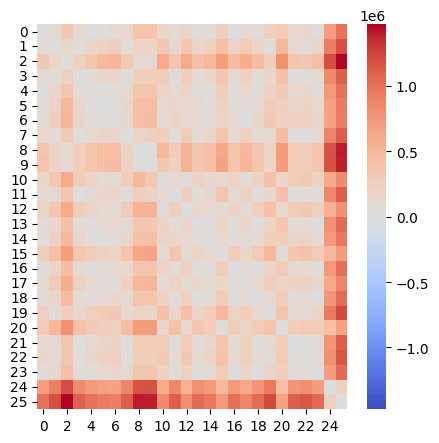

1 6641 4960634.3378710095
2 6642 6475569.9518984035
3 6644 12107982.371849455
4 6648 5349087.932936301
5 6650 5006620.936274899
6 6654 5496725.126568293
7 10175 5751619.169426551
8 3799 5696711.859748026
9 6666 10636024.018291788
10 3491 10549766.40184653
11 3816 6599246.874070705
12 6672 5306580.9864931125
13 6680 7059392.064863285
14 6683 5012671.038057327
15 6685 5349546.230966999
16 6687 8439745.908955175
17 6691 5153246.87097729
18 6693 6008959.4439395955
19 6694 5143106.790895404
20 6695 7336462.434589893
21 6698 9098443.411988689
22 6699 5466857.420582683
23 6700 5878592.6277684765
24 3801 5069782.610363301
25 6706 19041643.14997728
26 7013 25362597.78712491


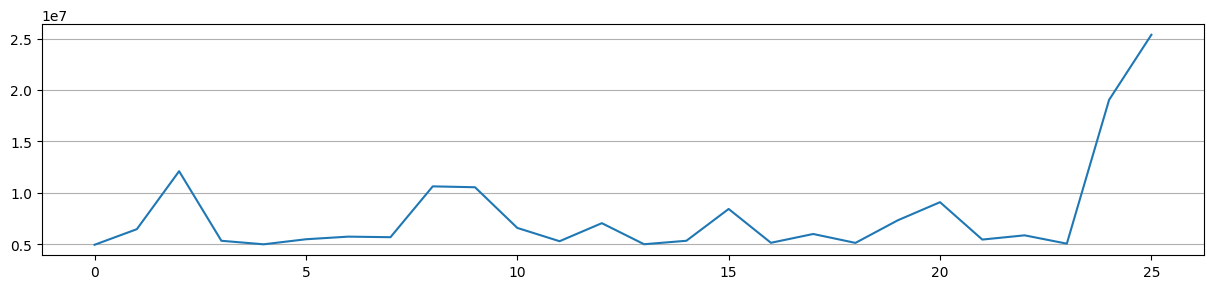

********************************* PM_LI VELOCIDAD *********************************


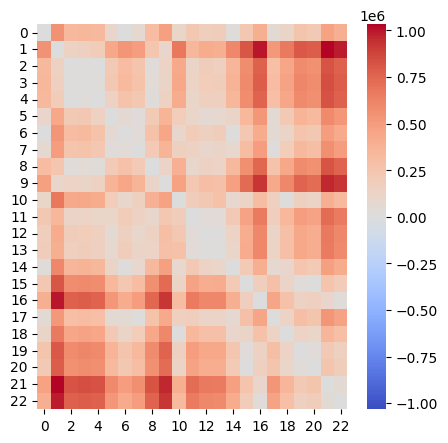

1 6643 5408038.975022527
2 6645 11939219.481472602
3 6647 7528494.703206566
4 6649 7837846.182075519
5 6651 7418587.52034791
6 6655 5332252.924380268
7 10265 5163312.163956551
8 3819 5277381.240122875
9 3800 7322010.682522379
10 3488 10108945.124327263
11 3490 5766748.161292244
12 3492 6171630.816790856
13 6670 5823938.96529962
14 6673 5844045.243352726
15 6677 5421444.959858259
16 6681 7669540.277160963
17 7125 10744603.208086358
18 6813 5388426.60213765
19 10180 6168895.751326155
20 6815 7960021.740308837
21 6817 7480793.48440007
22 7130 12152530.294509929
23 7014 10829910.366732972


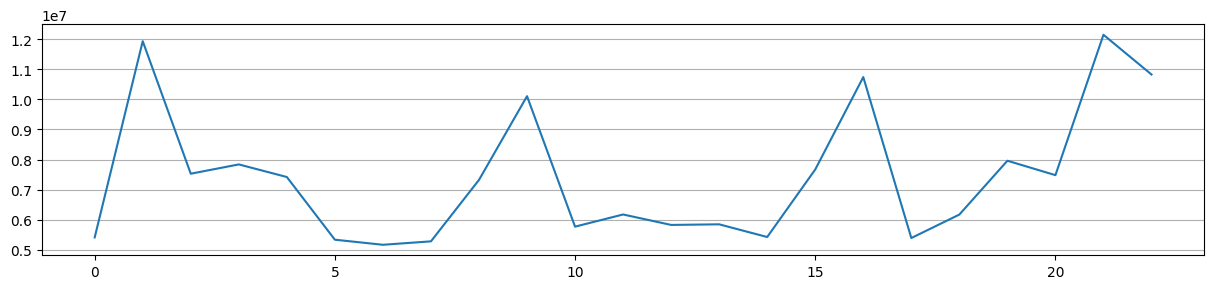

********************************* PM_TE VELOCIDAD *********************************


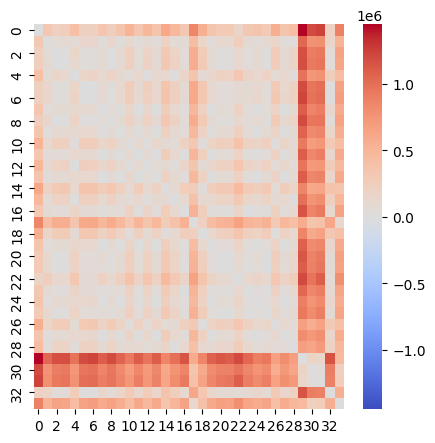

1 6713 15639556.789038852
2 3823 6485524.85210861
3 6715 7329069.725187693
4 6717 7377958.063621663
5 6720 7233009.796508802
6 6722 8106189.110808147
7 6725 8324827.393714739
8 6729 6626654.708403242
9 6734 7615947.822765845
10 6737 6539637.796545155
11 6743 8009564.211757075
12 6746 6563364.0217626635
13 6749 7604358.218777479
14 6753 6571460.027553305
15 6758 9935104.961399201
16 6763 7534331.445618244
17 6765 6980711.644978071
18 3532 15619196.837130437
19 3533 8647913.456586484
20 6766 6432180.451851029
21 6768 7135824.1879337905
22 3836 7089648.521074897
23 3558 10408224.397303745
24 6769 6753249.422709495
25 3597 6192285.127989558
26 6770 6690741.330465143
27 3598 7995236.59064575
28 3599 6089076.5698717
29 3560 6504405.791886161
30 6771 31727814.497085124
31 3494 24779178.497650422
32 6772 26184007.033288606
33 6775 8442091.21414962
34 6934 18100075.134444565


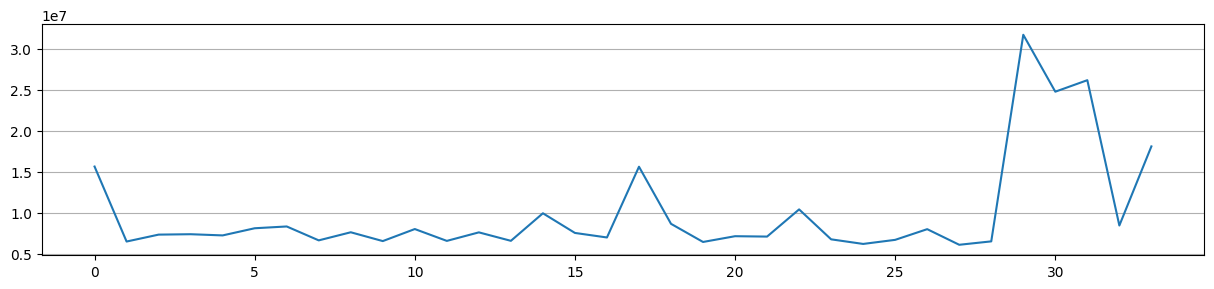

********************************* PM_LE VELOCIDAD *********************************


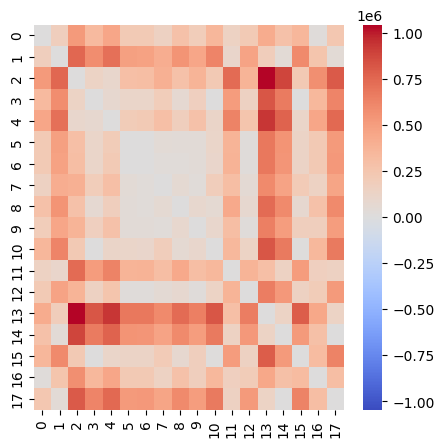

1 6714 4565003.511006955
2 6716 6916295.058327495
3 6723 8040180.323746554
4 6726 4888699.262716732
5 6730 6540077.77070489
6 6735 4028661.4980217107
7 6738 4034432.632871897
8 6739 4040327.7231018557
9 6744 4450223.811816239
10 6750 4084028.5380327255
11 10179 4901935.308406018
12 6754 5914958.276131811
13 6761 4211097.325256674
14 6948 10033289.237207046
15 3559 7604774.133472746
16 6697 4953269.754459091
17 6816 4775876.9194763275
18 6935 7491186.279287719


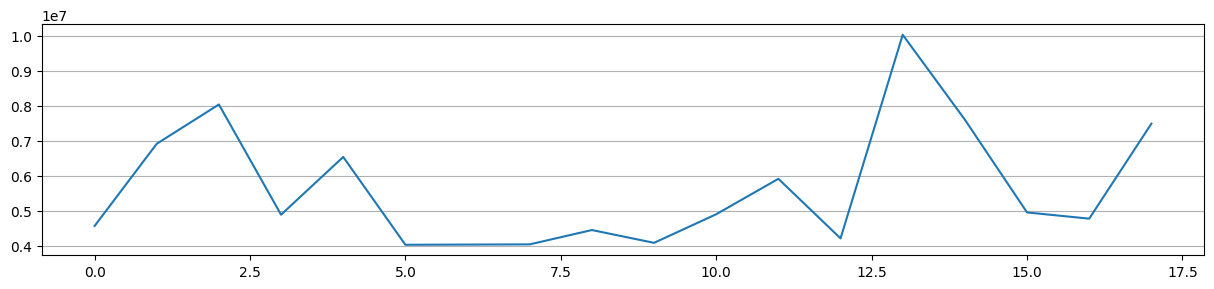

In [20]:
print("********************************* PM_TI VELOCIDAD *********************************")
buscaOutlayers(ids_PM_TI)
print("********************************* PM_LI VELOCIDAD *********************************")
buscaOutlayers(ids_PM_LI)
print("********************************* PM_TE VELOCIDAD *********************************")
buscaOutlayers(ids_PM_TE)
print("********************************* PM_LE VELOCIDAD *********************************")
buscaOutlayers(ids_PM_LE)


In [21]:
# Exportando datos
ids_PM_full = [ids_PM_TI, ids_PM_LI, ids_PM_TE, ids_PM_LE, ids_PM_nn]
# Archivo de los datos
nombrearchivo = "outputdata_m30_fulldates/m30_2024_data_fulldates_velocidad.txt"
datafile = open(nombrearchivo ,"w")
datafile.write(str(cantSensFinal)+" "+str(numFechas)+"\n")
for ids in ids_PM_full:
    for s in ids:
        datafile.write(str(s)+" ")
datafile.write("\n")
for ids in ids_PM_full:
    for s in ids:
        pos = dicc_posID[s]
        for c in range(numFechas):
            datafile.write(str(int(grillaVelocidad[pos][c]))+" ")
        datafile.write("\n")
datafile.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_data_fulldates_velocidad.txt escrito correctamente.


In [22]:
def exportarArchivoVecinos(diccVecinos, nombrearchivo):
    neigborfile = open(nombrearchivo,"w")
    neigborfile.write(str(len(diccVecinos))+"\n")
    for s in diccVecinos:
        neigborfile.write(str(s)+" ")
    neigborfile.write("\n")
    for s in diccVecinos:
        neigborfile.write(str(s) + " ")
        vec = diccVecinos[s]
        neigborfile.write(str(len(vec)))
        for v in vec:
            neigborfile.write(" " + str(v))
        neigborfile.write("\n")
    neigborfile.close()
    print("Archivo", nombrearchivo, "escrito correctamente.")

In [23]:
# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_estructura_velocidad.txt"
archivo = open(nombrearchivo,"w")
for ids in ids_PM_full:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in ids_PM_full:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_ids_estructura_velocidad.txt escrito correctamente.


In [24]:
# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_velocidad.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in ids_PM_full:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in ids_PM_full:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_listaVecindad_velocidad.txt escrito correctamente.


In [25]:
ids_PM_nn_SinOutlayers = ids_PM_nn.copy()
# Troncal Interior - Se elimina el 7013
ids_PM_TI_SinOutlayers = [6641, 6642, 6644, 6648, 6650, 6654, 10175, 3799, 6666, 3491, 3816, 6672, 6679, 6680, 6683, 6685, 6687, 6689, 6691, 6693, 6694, 6695, 6698, 6699, 6700, 3801, 6706]
ids_PM_nn_SinOutlayers.append(7013)
# Lateral Interior - Se eliminan sobre 1e9: [3819, 3490]
ids_PM_LI_SinOutlayers = [6643, 6645, 6647, 6649, 6651, 6655, 10265, 3800, 3488, 3492, 6670, 6673, 6677, 6681, 7125, 6813, 10180, 6815, 6817, 7130, 7014]
ids_PM_nn_SinOutlayers += [3819, 3490]
# Troncal Exterior - Se eliminan sobre 0.8e9: [3823, 6715, 3598, 3494, 6758, 6725]
ids_PM_TE_SinOutlayers = [6713, 6717, 6720, 6722, 6729, 6732, 6734, 6737, 6743, 6746, 6749, 6753, 6763, 6765, 3532, 3533, 6766, 6768, 3836, 3558, 6769, 3597, 6770, 3599, 3560, 6771, 6772, 6775, 6934]
ids_PM_nn_SinOutlayers += [3823, 6715, 3598, 3494, 6758, 6725]
# Lateral Exterior - Se eliminan sobre 0.5e8: [6738, 6948]
ids_PM_LE_SinOutlayers = [6714, 6716, 6723, 6726, 6730, 6735, 6739, 6744, 6750, 10179, 6754, 6761, 3559, 6697, 6816, 6935]
ids_PM_nn_SinOutlayers += [6738, 6948]
ids_PM_full_SinOutlayers = [ids_PM_TI_SinOutlayers, ids_PM_LI_SinOutlayers, ids_PM_TE_SinOutlayers, ids_PM_LE_SinOutlayers, ids_PM_nn_SinOutlayers]

In [26]:
# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_estructura_sinOutlayers_velocidad.txt"
archivo = open(nombrearchivo,"w")
for ids in ids_PM_full_SinOutlayers:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in ids_PM_full_SinOutlayers:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_ids_estructura_sinOutlayers_velocidad.txt escrito correctamente.


In [27]:
# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_SinOutlayers_velocidad.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in ids_PM_full_SinOutlayers:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in ids_PM_full_SinOutlayers:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_listaVecindad_SinOutlayers_velocidad.txt escrito correctamente.


In [28]:
# Calculando valores vs Diferencia con semana promedio por grupo
dicc_histograma_original = {}
dicc_histograma_diff_semana = {}
times_x_semana = 7 * 24 * 4
numSemanas = numFechas / times_x_semana
for lx in ids_PM_full_SinOutlayers:
    tope = len(lx)
    semana = np.zeros(times_x_semana)
    for i in range(tope):
        ids = lx[i]
        pos = dicc_posID[ids]
        for j in range(numFechas):
            val = grillaVelocidad[pos][j]
            semana[j % times_x_semana] += val
            if val not in dicc_histograma_original:
                dicc_histograma_original[val] = 1
            else:
                dicc_histograma_original[val] += 1
    for i in range(times_x_semana):
        semana[i] = int(semana[i] / numSemanas / len(lx))
    for i in range(tope):
        ids = lx[i]
        pos = dicc_posID[ids]
        for j in range(numFechas):
            val = grillaVelocidad[pos][j] - semana[j % times_x_semana]            
            if val not in dicc_histograma_diff_semana:
                dicc_histograma_diff_semana[val] = 1
            else:
                dicc_histograma_diff_semana[val] += 1

In [29]:
cants_original = list(dicc_histograma_original.keys())
cants_semana = list(dicc_histograma_diff_semana.keys())
cants_original.sort()
cants_semana.sort()

In [30]:
# Prueba para promedio de una semana para un sensor:
dicc_Or = {}
dicc_Pr = {}
semana = np.zeros(times_x_semana)
pos = dicc_posID[ids_PM_TI[0]]
sx = grillaVelocidad[pos]
print("len sx:", len(sx))
for i in range(len(sx)):
    if sx[i] not in dicc_Or:
        dicc_Or[sx[i]] = 1
    else:
        dicc_Or[sx[i]] += 1
    porcion = sx[i] / numSemanas
    semana[i % times_x_semana] += porcion
for i in range(times_x_semana):
    semana[i] = int(semana[i])
for i in range(len(sx)):
    val = sx[i] - semana[i % times_x_semana]            
    if val not in dicc_Pr:
        dicc_Pr[val] = 1
    else:
        dicc_Pr[val] += 1
cOr = list(dicc_Or.keys())
cOr.sort()
cPr = list(dicc_Pr.keys())
cPr.sort()
print("Prueba OR:", cOr[0], cOr[-1])
print("Prueba PR:", cPr[0], cPr[-1])

len sx: 35136
Prueba OR: 0 100
Prueba PR: -87.0 47.0


In [31]:
# Método de un promedio por sensor
dicc_histograma_diff_semana_1xsen = {}
for lx in ids_PM_full_SinOutlayers:
    for idx in lx:
        semana = np.zeros(times_x_semana)
        pos = dicc_posID[idx]
        sx = grillaVelocidad[pos]
        for i in range(len(sx)):
            porcion = sx[i] / numSemanas
            semana[i % times_x_semana] += porcion
        for i in range(times_x_semana):
            semana[i] = int(semana[i])
        for i in range(len(sx)):
            val = sx[i] - semana[i % times_x_semana]            
            if val not in dicc_histograma_diff_semana_1xsen:
                dicc_histograma_diff_semana_1xsen[val] = 1
            else:
                dicc_histograma_diff_semana_1xsen[val] += 1
cants_1xsemana = list(dicc_histograma_diff_semana_1xsen.keys())
cants_1xsemana.sort()

In [32]:
print("------ Rangos ------")
print("Original:\t", cants_original[0], "\t", cants_original[-1])
print("Metodo semana:\t", cants_semana[0], "\t", cants_semana[-1])
print("1 x sensor:\t", cants_1xsemana[0], "\t", cants_1xsemana[-1])


------ Rangos ------
Original:	 -2 	 235
Metodo semana:	 -92.0 	 166.0
1 x sensor:	 -104.0 	 185.0


In [33]:
histomin = min(min(int(cants_original[0]), int(cants_semana[0])), int(cants_1xsemana[0]))
histomax = max(max(int(cants_original[-1]), int(cants_semana[-1])), int(cants_1xsemana[-1]))
dataOriginal = []
dataXsemana = []
dataSsensor = []
ejex = []
for i in range(histomin, histomax+1):
    ejex.append(i)
    if i in dicc_histograma_original:
        dataOriginal.append(dicc_histograma_original[i])
    else:
        dataOriginal.append(0)
    if i in dicc_histograma_diff_semana:
        dataXsemana.append(dicc_histograma_diff_semana[i])
    else:
        dataXsemana.append(0)
    if i in dicc_histograma_diff_semana_1xsen:
        dataSsensor.append(dicc_histograma_diff_semana_1xsen[i])
    else:
        dataSsensor.append(0)


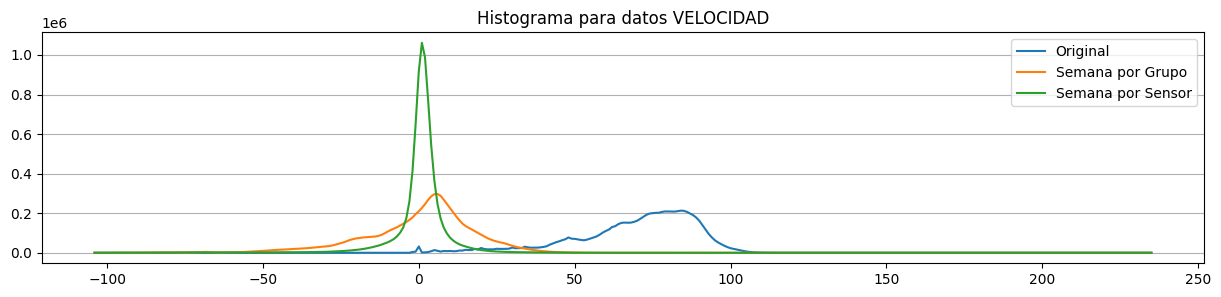

In [34]:
plt.figure(figsize=(15,3))
plt.plot(ejex, dataOriginal, label='Original')
plt.plot(ejex, dataXsemana, label='Semana por Grupo')
plt.plot(ejex, dataSsensor, label='Semana por Sensor')
plt.title("Histograma para datos VELOCIDAD")
#plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
plt.grid(axis='y')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [35]:
def plotSerie(idSerie):
    ps = dicc_posID[idSerie]
    if idSerie not in dicc_posID:
        print("ID " + str(idSerie) + " no encontrado")
        return
    plt.figure(figsize=(15,3))
    plt.plot(grillaVelocidadOriginal[ps], label="Original")
    plt.plot(grillaVelocidad[ps], label="Corregida")
    plt.title('Velocidad sensor '+str(idSerie))
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()

In [36]:
ticks = []
for i in range(8):
    ticks.append(i*24*4)

def plotPrimeraSemana(IDsSemana):
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaVelocidad[ps][:times_x_semana], label=str(i))
    plt.title('Velocidad 1a Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

def plotSegundaSemana(IDsSemana):
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaVelocidad[ps][times_x_semana:2*times_x_semana], label=str(i))
    plt.title('Velocidad 2a Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

def plotUltimaSemana(IDsSemana):
    timesAux = numFechas - times_x_semana
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaVelocidad[ps][timesAux:], label=str(i))
    plt.title('Velocidad Última Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

In [37]:
def estadisticasLista(listaIDs):
    acumTotal = 0
    for ids in listaIDs:
        acumLista = 0
        ps = dicc_posID[ids]
        for x in grillaVelocidad[ps]:
            acumLista += x
        acumTotal += float(acumLista) / numFechas
    minimo = x
    maximo = x
    promedioTotal = acumTotal / len(listaIDs)
    sumatoria = 0
    for ids in listaIDs:
        ps = dicc_posID[ids]
        minimo = min(minimo, min(grillaVelocidad[ps]))
        maximo = max(maximo, max(grillaVelocidad[ps]))
        for x in grillaVelocidad[ps]:
            diferencia = x - promedioTotal
            sumatoria += (diferencia * diferencia)
    varianza = sumatoria / (len(listaIDs) * numFechas)
    desviacion = math.sqrt(varianza)
    print("Mínimo:", minimo)
    print("Máximo:", maximo)
    print("Promedio:", round(promedioTotal,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))
    

In [38]:
print("********************************* Estadísticas PM_TI VELOCIDAD *********************************")
estadisticasLista(ids_PM_TI)
print("********************************* Estadísticas PM_LI VELOCIDAD *********************************")
estadisticasLista(ids_PM_LI)
print("********************************* Estadísticas PM_TE VELOCIDAD *********************************")
estadisticasLista(ids_PM_TE)
print("********************************* Estadísticas PM_LE VELOCIDAD *********************************")
estadisticasLista(ids_PM_LE)
print("********************************* Estadísticas PM_NN VELOCIDAD *********************************")
estadisticasLista(ids_PM_nn)
print("********************************* Estadísticas TODOS VELOCIDAD *********************************")
estadisticasLista(list_IDs_final)

********************************* Estadísticas PM_TI VELOCIDAD *********************************
Mínimo: 0
Máximo: 198
Promedio: 80.75
Varianza: 262.17
Desviación estándar: 16.19
********************************* Estadísticas PM_LI VELOCIDAD *********************************
Mínimo: 0
Máximo: 111
Promedio: 70.11
Varianza: 259.05
Desviación estándar: 16.1
********************************* Estadísticas PM_TE VELOCIDAD *********************************
Mínimo: 0
Máximo: 118
Promedio: 77.34
Varianza: 272.16
Desviación estándar: 16.5
********************************* Estadísticas PM_LE VELOCIDAD *********************************
Mínimo: 0
Máximo: 120
Promedio: 69.8
Varianza: 290.41
Desviación estándar: 17.04
********************************* Estadísticas PM_NN VELOCIDAD *********************************
Mínimo: 0
Máximo: 235
Promedio: 65.24
Varianza: 405.8
Desviación estándar: 20.14
********************************* Estadísticas TODOS VELOCIDAD *********************************
Mínimo: 0
Má

In [39]:
def estadisticasListaValores(listaValores):
    acumulado = 0
    for x in listaValores:
        acumulado += x
    promedio = float(acumulado) / len(listaValores)
    sumatoria = 0
    for x in listaValores:
        diferencia = x - promedio
        sumatoria += (diferencia * diferencia)
    varianza = sumatoria / len(listaValores)
    desviacion = math.sqrt(varianza)
    print("Mínimo:", min(listaValores))
    print("Máximo:", max(listaValores))
    print("Promedio:", round(promedio,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))

In [40]:
def estadisticasHistograma(listaValores):
    acumulado = 0
    minimo = histomax
    maximo = histomin
    valor = histomin
    cantidad = 0
    for x in listaValores:
        if x > 0:
            acumulado += (x * valor)
            cantidad += x
            minimo = min(minimo, valor)
            maximo = max(maximo, valor)
        valor += 1
    promedio = float(acumulado) / cantidad
    sumatoria = 0
    valor = histomin
    for x in listaValores:
        diferencia = valor - promedio
        sumatoria += (diferencia * diferencia * x)
        valor += 1
    varianza = sumatoria / cantidad
    desviacion = math.sqrt(varianza)
    print("Mínimo:", minimo)
    print("Máximo:", maximo)
    print("Promedio:", round(promedio,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))

In [41]:
print(" *************************** Estadísticas Histograma VELOCIDAD datos Originales ***************************")
estadisticasHistograma(dataOriginal)
print(" *************************** Estadísticas Histograma VELOCIDAD datos Semana por grupo ***************************")
estadisticasHistograma(dataXsemana)
print(" *************************** Estadísticas Histograma VELOCIDAD datos Semana por sensor ***************************")
estadisticasHistograma(dataSsensor)

 *************************** Estadísticas Histograma VELOCIDAD datos Originales ***************************
Mínimo: -2
Máximo: 235
Promedio: 69.57
Varianza: 384.63
Desviación estándar: 19.61
 *************************** Estadísticas Histograma VELOCIDAD datos Semana por grupo ***************************
Mínimo: -92
Máximo: 166
Promedio: 0.51
Varianza: 311.41
Desviación estándar: 17.65
 *************************** Estadísticas Histograma VELOCIDAD datos Semana por sensor ***************************
Mínimo: -104
Máximo: 185
Promedio: 0.5
Varianza: 85.53
Desviación estándar: 9.25


In [42]:
def plotHistograma(listaDiccValores, listaTitulos, tituloGrafica):
    arrMin = []
    arrMax = []
    for i in listaDiccValores:
        v = list(i.keys())
        arrMin.append(min(v))
        arrMax.append(max(v))
    print("Valores minimos:", arrMin)
    print("Valores máximos:", arrMax)
    minmin = min(arrMin)
    maxmax = max(arrMax)
    plt.figure(figsize=(15,3))
    ejex = []
    for i in range(minmin, maxmax+1):
        ejex.append(i)
    for d in range(len(listaDiccValores)):
        valores = []
        for i in range(minmin, maxmax+1):
            if i in listaDiccValores[d]:
                valores.append(listaDiccValores[d][i])
            else:
                valores.append(0)
        plt.plot(ejex, valores, label=listaTitulos[d])
    plt.title("Histograma para datos Velocidad")
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()

In [43]:
def diccionarioHistoDeLista(lista):
    diccHisto = {}
    for x in lista:
        if x in diccHisto:
            diccHisto[x] += 1
        else:
            diccHisto[x] = 1
    return diccHisto

In [44]:
def diccionarioHistogramaPorID(idSensor):
    if idSensor not in dicc_posID:
        return {}
    ps = dicc_posID[idSensor]
    return diccionarioHistoDeLista(grillaVelocidad[ps])

In [45]:
def graficaPromedioBloquesPorSerie(listaIDs, numSeriesGrafica, numBloquesGrafica):
    if len(listaIDs) < numSeriesGrafica:
        numSeriesGrafica = len(listaIDs)
    promedio_horas = []
    for ids in listaIDs[:numSeriesGrafica]:
        ph = np.zeros(numBloquesGrafica)
        ps = dicc_posID[ids]
        for p in range(numFechas):
            ph[p%numBloquesGrafica] += grillaVelocidad[ps][p]
        muestrasXhora = numFechas/numBloquesGrafica
        for p in range(numBloquesGrafica):
            ph[p] = ph[p] / muestrasXhora
        promedio_horas.append(ph)
    plt.figure(figsize=(15,3))
    for s in range(numSeriesGrafica):
        plt.plot(promedio_horas[s], label=str(listaIDs[s]))
    plt.title('Promedio de Velocidad por '+str(numBloquesGrafica)+' bloques de 15m.')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    ticks = range(numBloquesGrafica)
    #plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

*********************************** Muestra para TI ***********************************


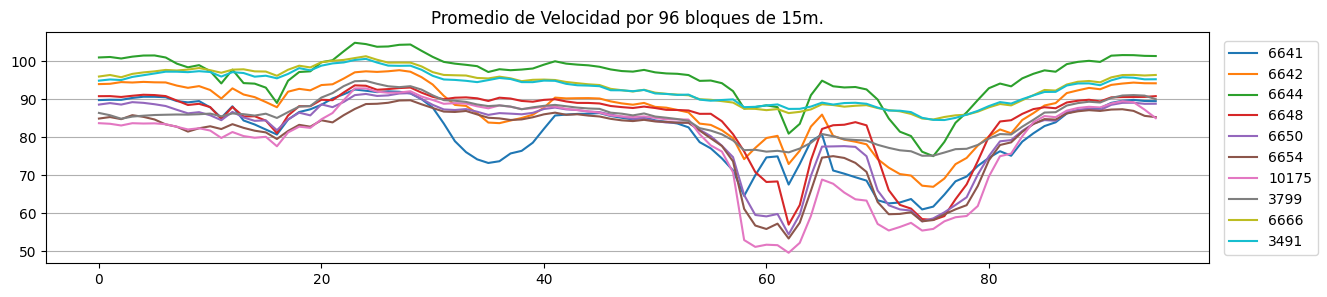

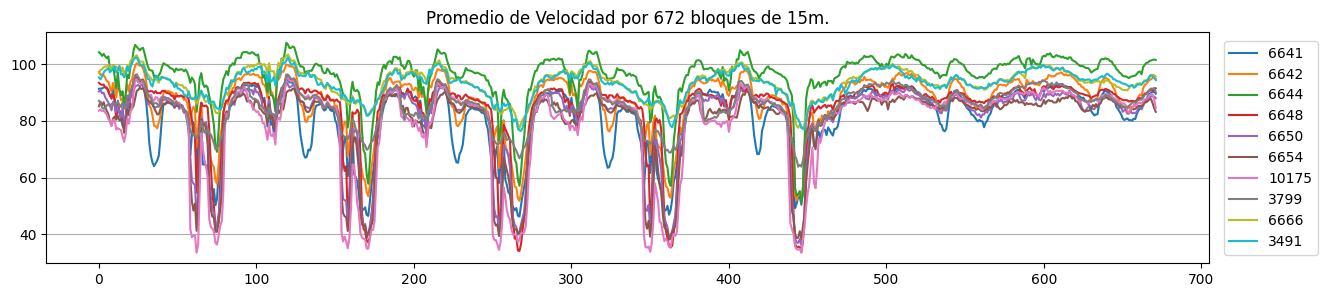

In [46]:
print("*********************************** Muestra para TI ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_TI, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_TI, 10, 672)

*********************************** Muestra para TE ***********************************


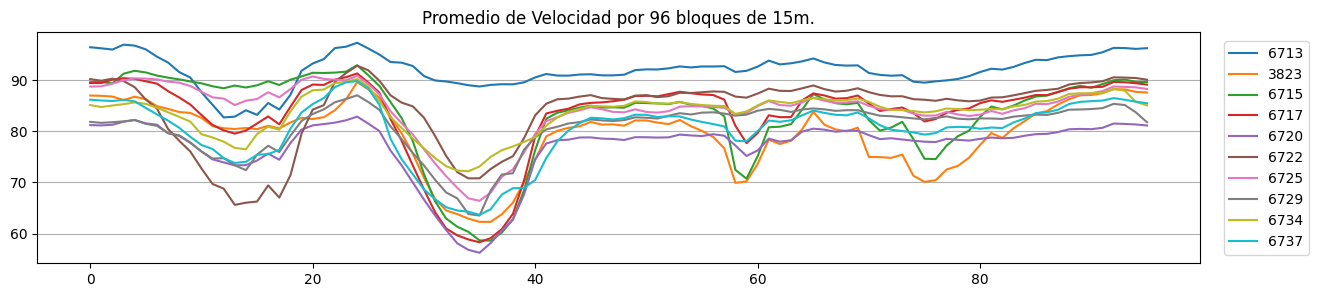

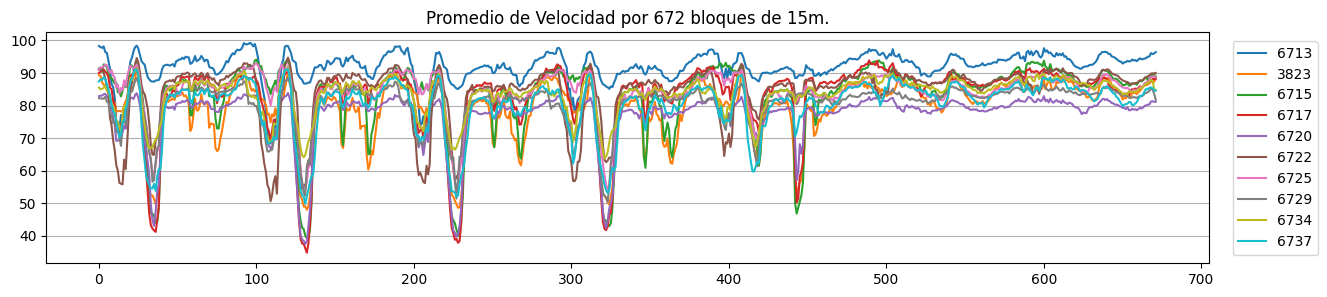

In [47]:
print("*********************************** Muestra para TE ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_TE, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_TE, 10, 672)

*********************************** Muestra para LI ***********************************


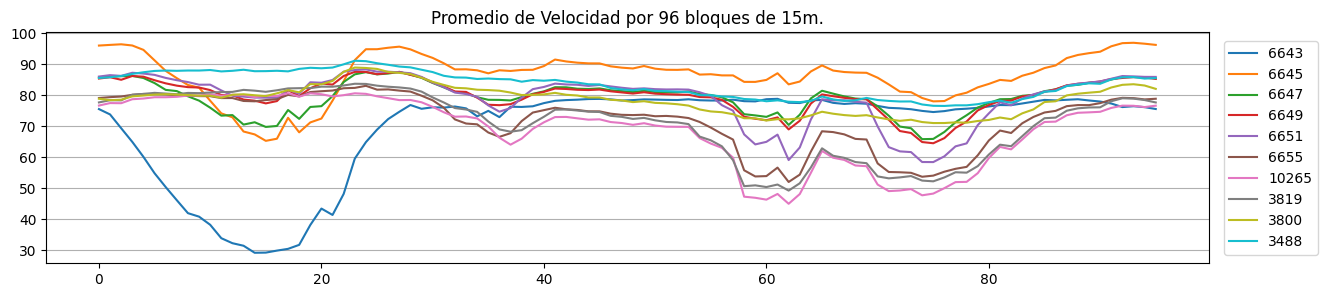

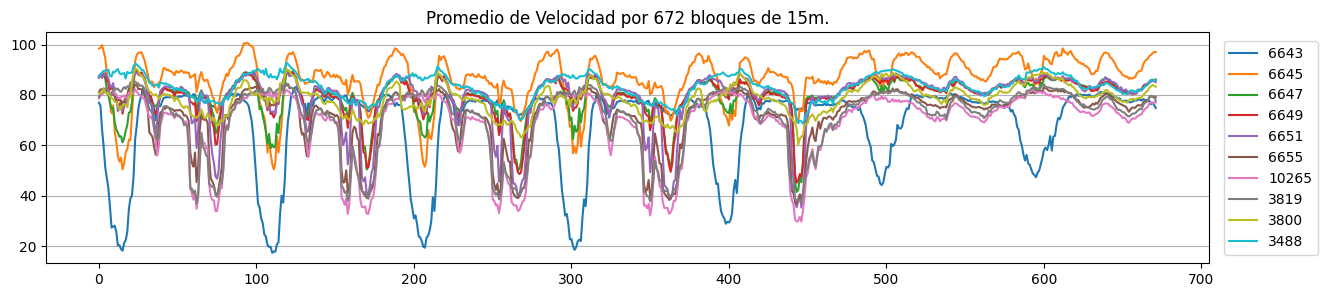

In [48]:
print("*********************************** Muestra para LI ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_LI, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_LI, 10, 672)

*********************************** Muestra para LE ***********************************


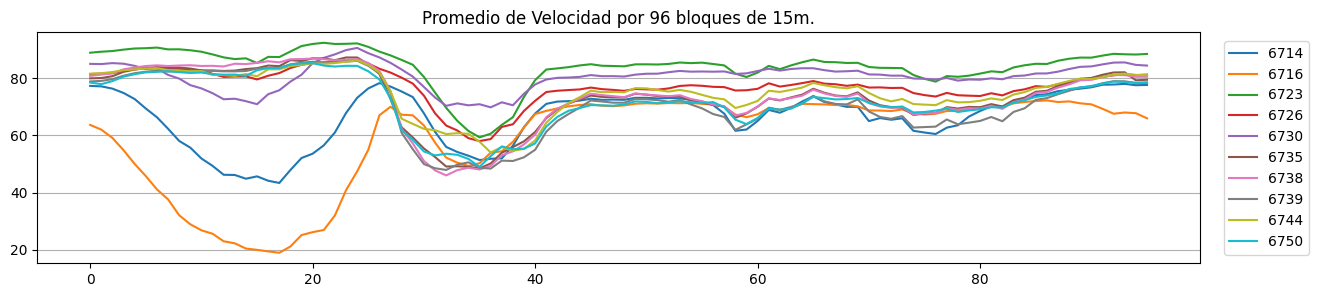

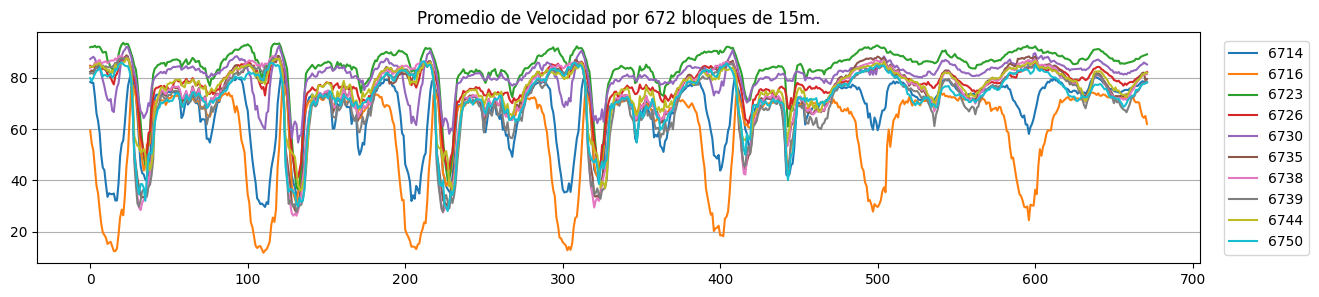

In [49]:
print("*********************************** Muestra para LE ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_LE, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_LE, 10, 672)

*********************************** Muestra para nn ***********************************


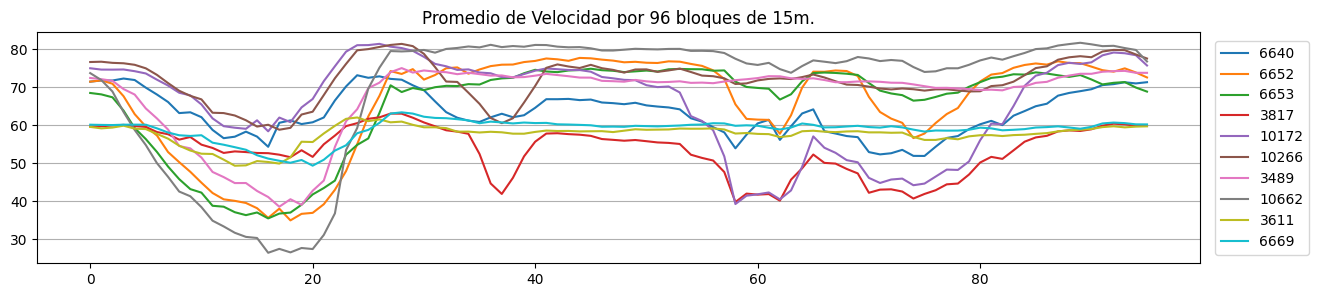

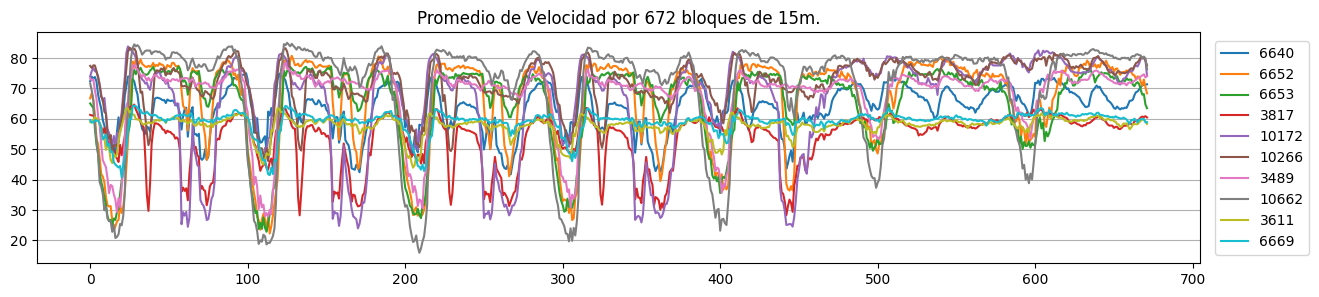

In [50]:
print("*********************************** Muestra para nn ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_nn, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_nn, 10, 672)

In [51]:
def distanciaEuclideaSerie(listaA, listaB):
    if len(listaA) != len(listaB):
        print("Error! el largo de la lista no coincide.")
        return 'Error'
    sumatoria = 0
    n = len(listaA)
    for i in range(n):
        dif = listaA[i] - listaB[i]
        sumatoria += (dif * dif)
    distEucSerie = sumatoria / n
    return sumatoria

In [52]:
def matrizDistanciaEuclideaSerie(listaIDs, factor):
    numSeries = len(listaIDs)
    matriz = np.zeros((numSeries, numSeries))
    for i in range(numSeries):
        id1 = listaIDs[i]
        if id1 in dicc_posID:
            ps1 = dicc_posID[id1]
            for j in range(i+1, numSeries):
                id2 = listaIDs[j]
                if id2 in dicc_posID:
                    ps2 = dicc_posID[id2]
                    des = distanciaEuclideaSerie(grillaVelocidad[ps1], grillaVelocidad[ps2])
                    des /= factor
                    matriz[i][j] = des
                    matriz[j][i] = des
    for i in range(numSeries):
        print("\t"+str(listaIDs[i]), end="")
    print("")
    for i in range(numSeries):
        print(listaIDs[i], end="\t")
        for j in range(numSeries):
            print(round(matriz[i][j], 2), end="\t")
        print("")
    return matriz

In [53]:
m = matrizDistanciaEuclideaSerie(ids_PM_TI[:10], 100000)

	6641	6642	6644	6648	6650	6654	10175	3799	6666	3491
6641	0.0	28.48	109.0	62.3	50.51	66.29	109.87	77.57	102.81	107.57	
6642	28.48	0.0	50.94	50.47	54.8	77.85	130.75	64.36	53.77	60.41	
6644	109.0	50.94	0.0	75.02	114.35	153.76	214.58	100.41	38.3	46.54	
6648	62.3	50.47	75.02	0.0	35.57	59.41	111.72	89.21	97.99	104.52	
6650	50.51	54.8	114.35	35.57	0.0	22.84	79.85	84.48	113.6	120.3	
6654	66.29	77.85	153.76	59.41	22.84	0.0	68.59	99.22	145.42	151.22	
10175	109.87	130.75	214.58	111.72	79.85	68.59	0.0	91.74	204.43	210.52	
3799	77.57	64.36	100.41	89.21	84.48	99.22	91.74	0.0	62.67	73.62	
6666	102.81	53.77	38.3	97.99	113.6	145.42	204.43	62.67	0.0	16.01	
3491	107.57	60.41	46.54	104.52	120.3	151.22	210.52	73.62	16.01	0.0	


In [54]:
m = matrizDistanciaEuclideaSerie(list_IDs_final, 100000)

	6640	6641	6642	6643	6644	6645	6647	6648	6649	6650	6651	6652	6653	6654	6655	10175	10265	3817	3819	10172	10266	3799	3800	6666	3488	3489	10662	3611	6669	6668	3490	3491	3492	3493	3816	6670	6672	6673	6674	6677	6678	6680	6681	6682	6683	6684	6685	6686	6687	6688	10660	6691	7125	6693	6694	6813	6695	10659	10180	6698	6815	6817	6699	6700	3801	6706	7130	7013	7014	6713	3821	3822	3823	6714	6715	6716	6717	6719	6720	6722	6723	6725	6726	6729	6730	6731	10661	6734	6735	6736	10194	6737	6738	6739	6740	6742	6741	10267	6743	6744	6745	6746	7126	6748	10177	6749	6750	10179	10178	6753	6754	6755	6757	6758	6759	6760	6761	6763	6764	6765	3531	3532	3533	6948	6766	6768	3836	3558	3559	6769	6697	3597	6816	6770	3598	3599	3560	6771	3494	6772	6774	6775	6934	6935	3521	6712	3837	3539	3536	3495	3561	6667	3600	3838	3839	6777	7127	6778	6779	6822	6780	6938	6939	6942	6949	6950	6781	6782	3496	6783	6784	6785	6932	7128	3797	10198	10200	10201	10199	3538	6789	10176	6661	6790	7131	3827	3828	3826	6791	6792	10204	10203	10268	6762	10205	1

10204 6795 6935 3532


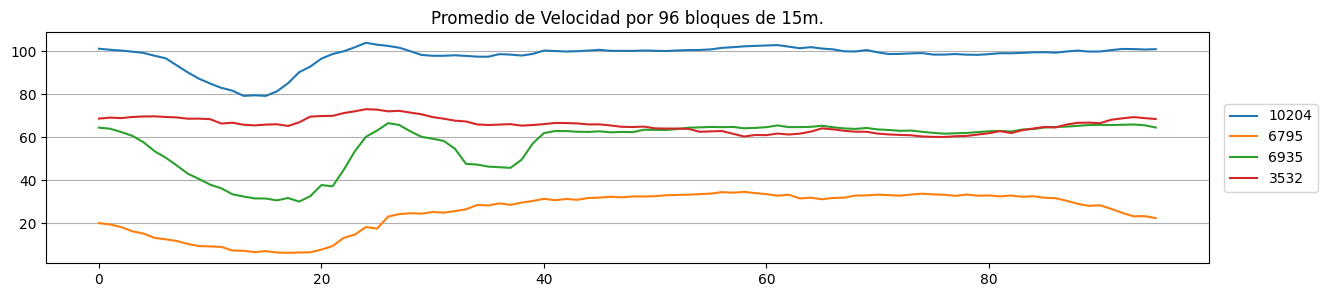

In [55]:
maxmatriz = m[0][1]
fmax = [0]
cmax = [1]
for f in range(len(m)):
    for c in range(len(m[f])):
        if m[f][c] > maxmatriz:
            maxmatriz = m[f][c]
            fmax = f
            cmax = c
idF = list_IDs_final[fmax]
idC = list_IDs_final[cmax]
distF = m[fmax].copy()
distF.sort()
vft = distF[0] + ((distF[-1] - distF[0])/3)
i = 0
while distF[i] < vft:
    i+=1
vft = distF[i]
ftercio = 0
while ftercio < len(m) and m[fmax][ftercio] != vft:
    ftercio+=1
idFM = list_IDs_final[ftercio]
distC = m[cmax].copy()
distC.sort()
vct = distC[0] + ((distC[-1] - distC[0])/3)
i = 0
while distC[i] < vct:
    i+=1
vct = distC[i]
ctercio = 0
while ctercio < len(m) and m[cmax][ctercio] != vct:
    ctercio+=1
idCM = list_IDs_final[ctercio]
print(idF, idC, idFM, idCM)
l = [idF, idC, idFM, idCM]
graficaPromedioBloquesPorSerie(l, 4, 96)

In [56]:
print(fmax, cmax, ftercio, ctercio)
print(list_IDs_final[fmax], list_IDs_final[cmax], list_IDs_final[ftercio], list_IDs_final[ctercio])
listA = []
listB = []
listC = []
listD = []
listasDES = [listA, listB, listC, listD]
listaPOS = [fmax, cmax, ftercio, ctercio]
print("max euc dist:", m[fmax][cmax])
for i in range(len(m)):
    minI = m[fmax][cmax]
    posMin = -1
    for j in range(len(listasDES)):
        if m[i][listaPOS[j]] < minI:
            minI = m[i][listaPOS[j]]
            posMin = j
    listasDES[posMin].append(list_IDs_final[i])
for lis in listasDES:
    print(len(lis))

190 208 143 121
10204 6795 6935 3532
max euc dist: 1904.81234
42
8
67
115


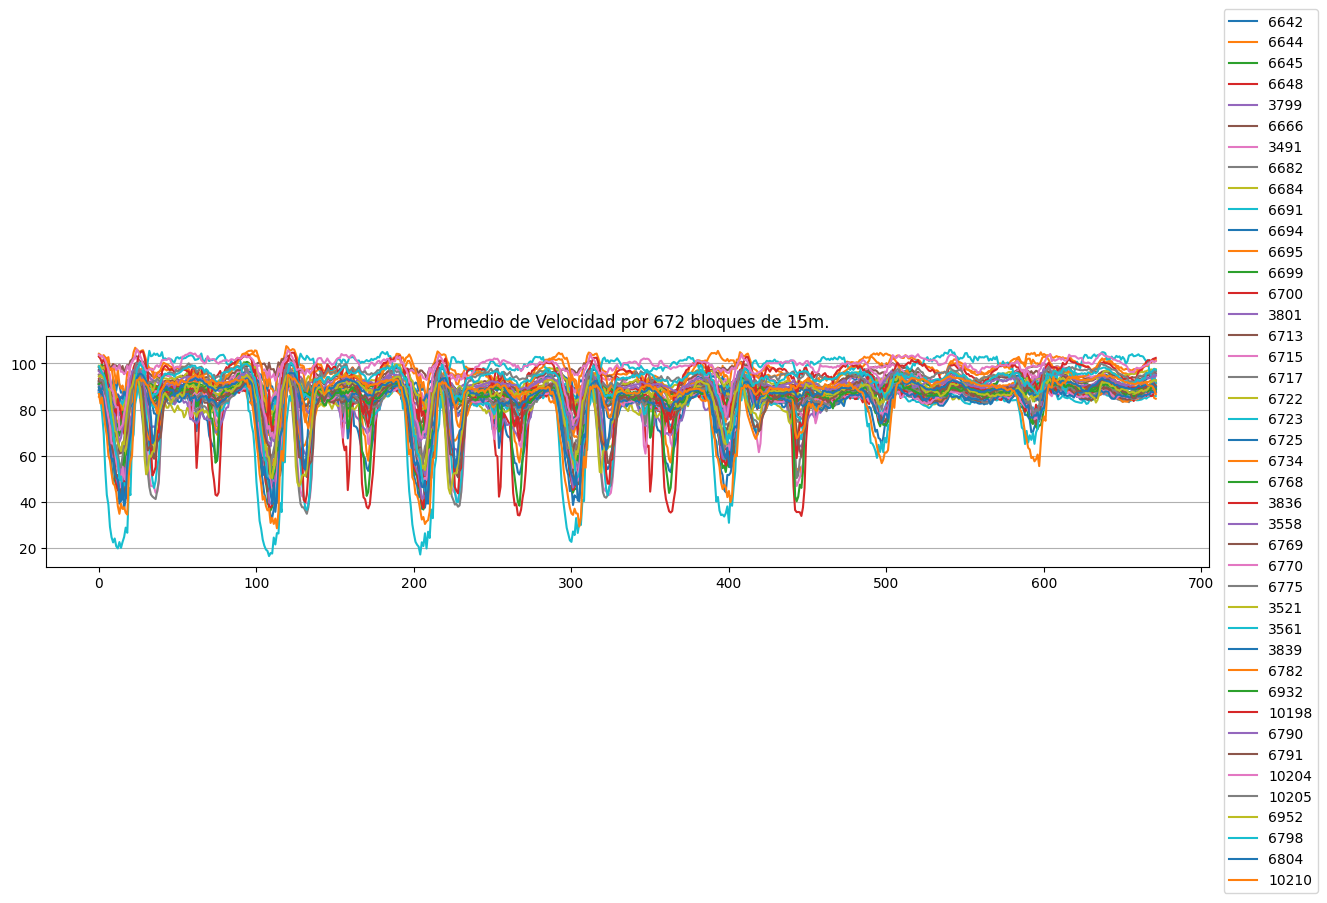

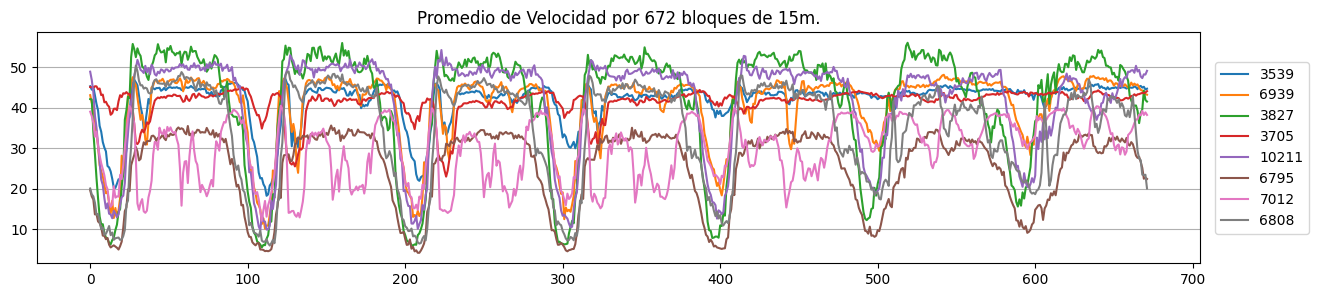

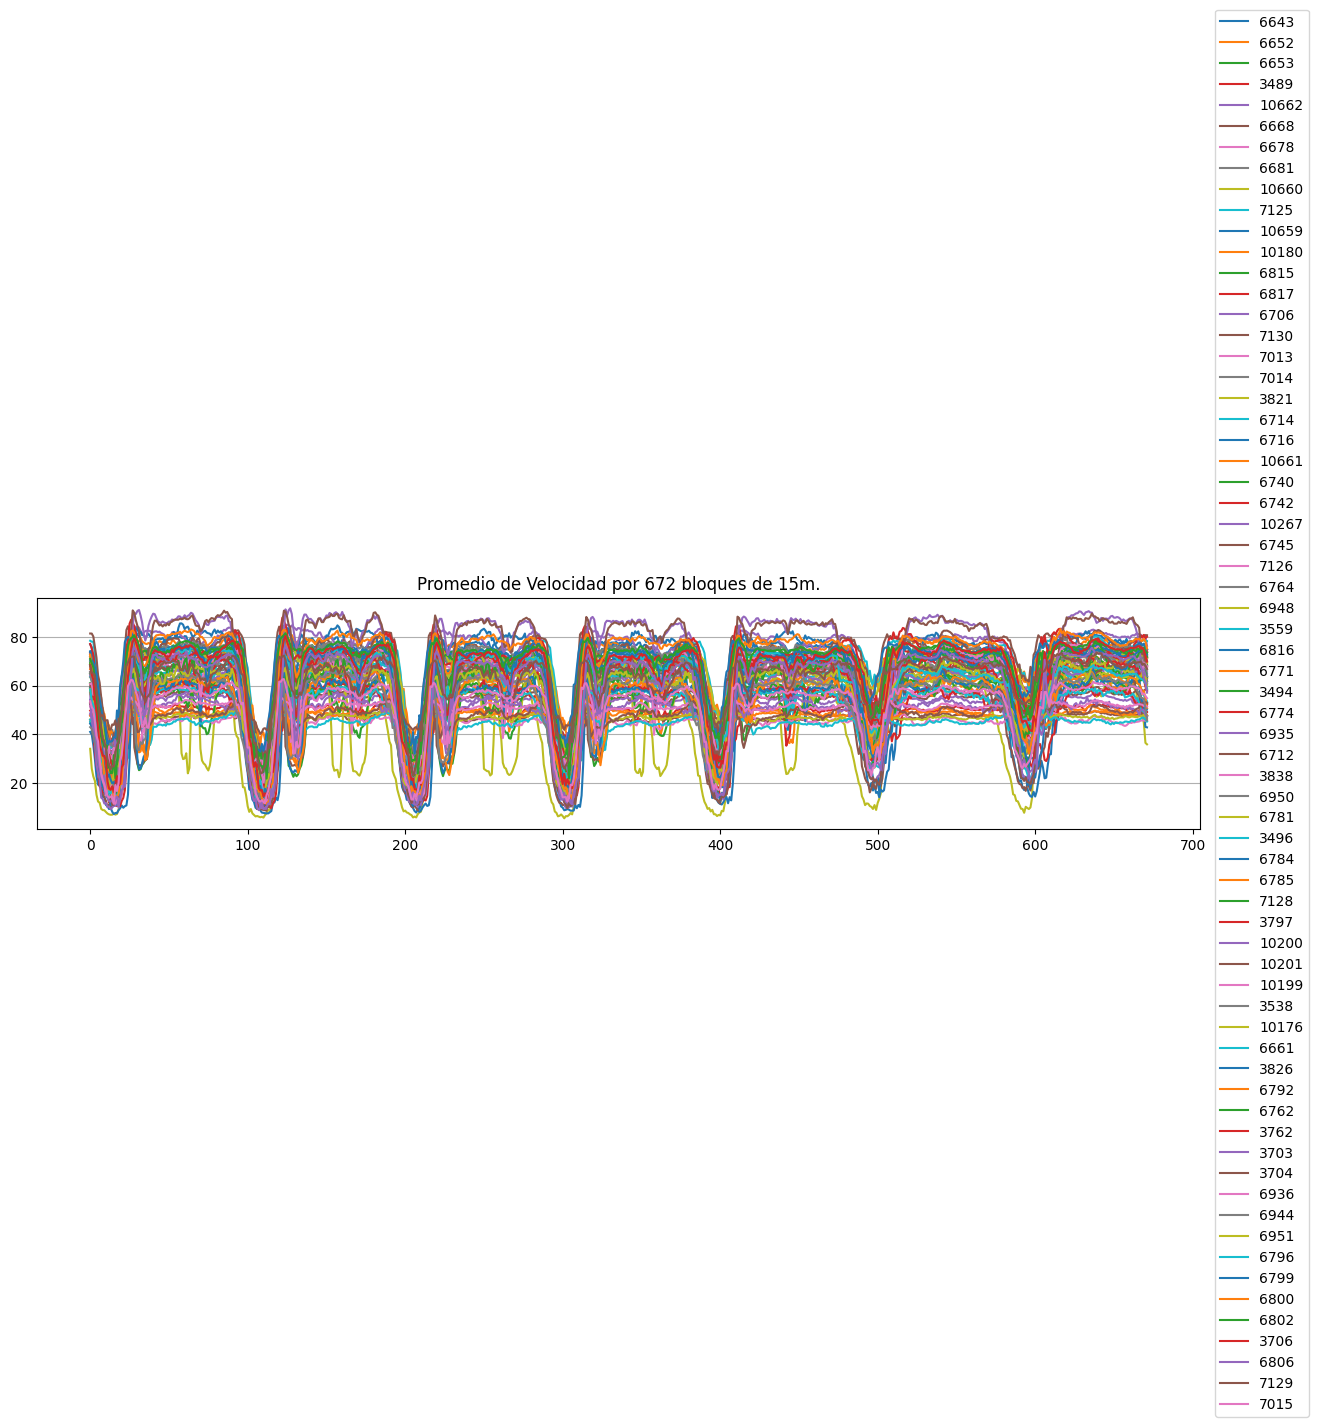

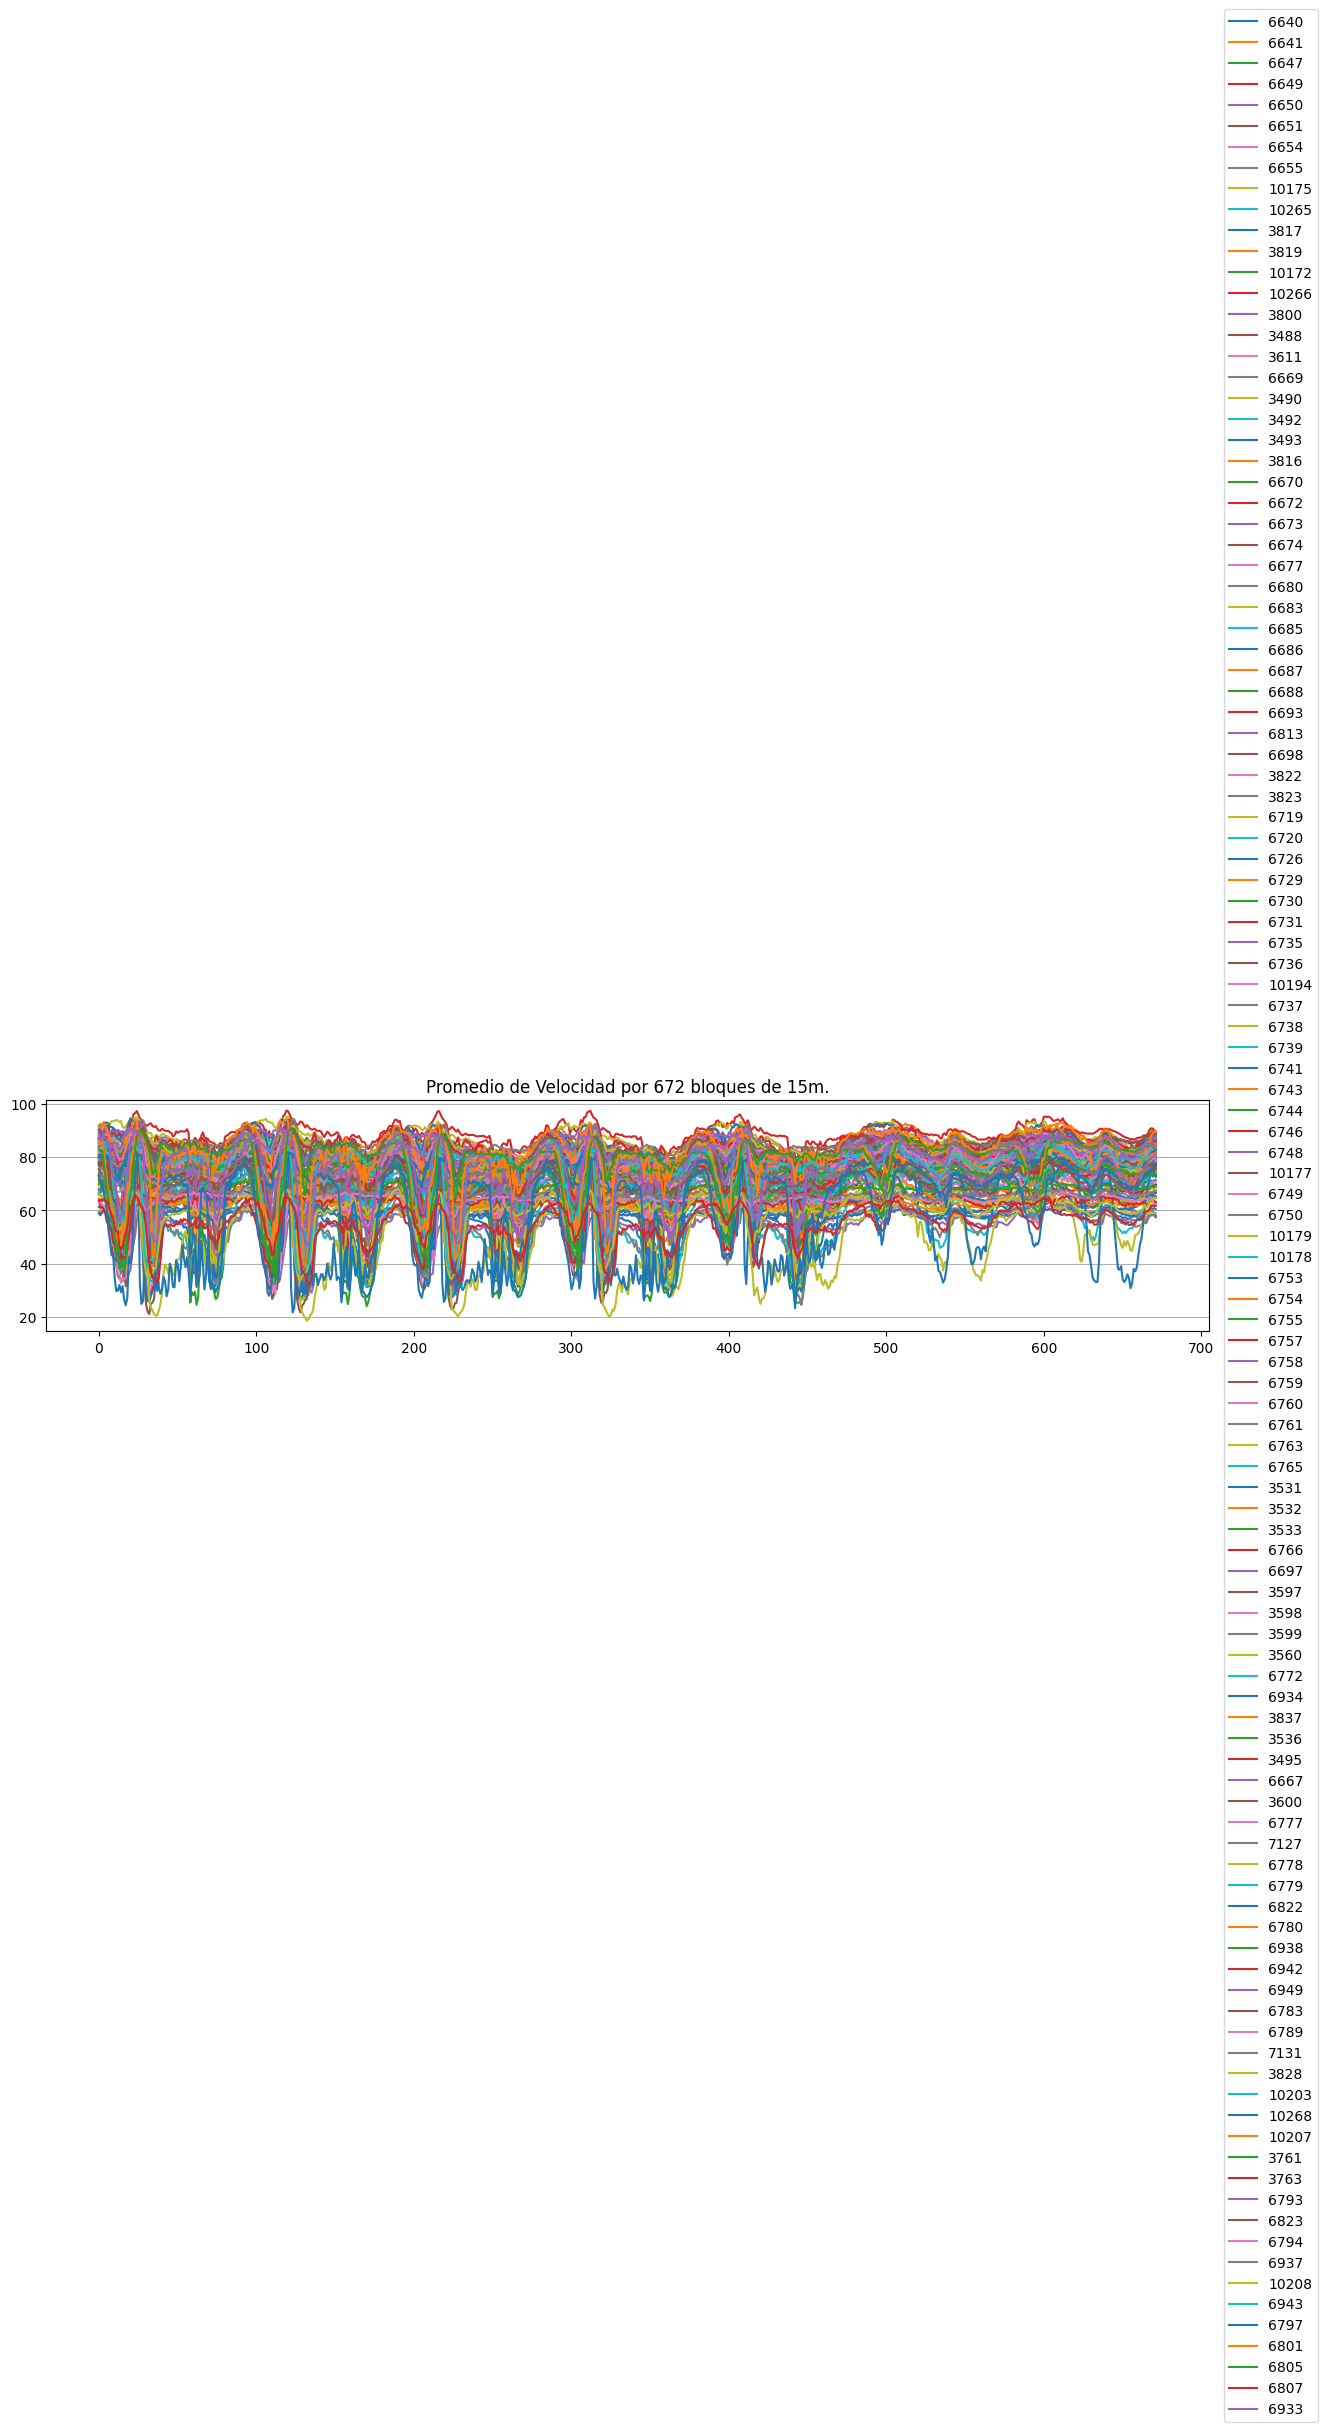

In [57]:
for lis in listasDES:
    graficaPromedioBloquesPorSerie(lis, len(lis), 672)

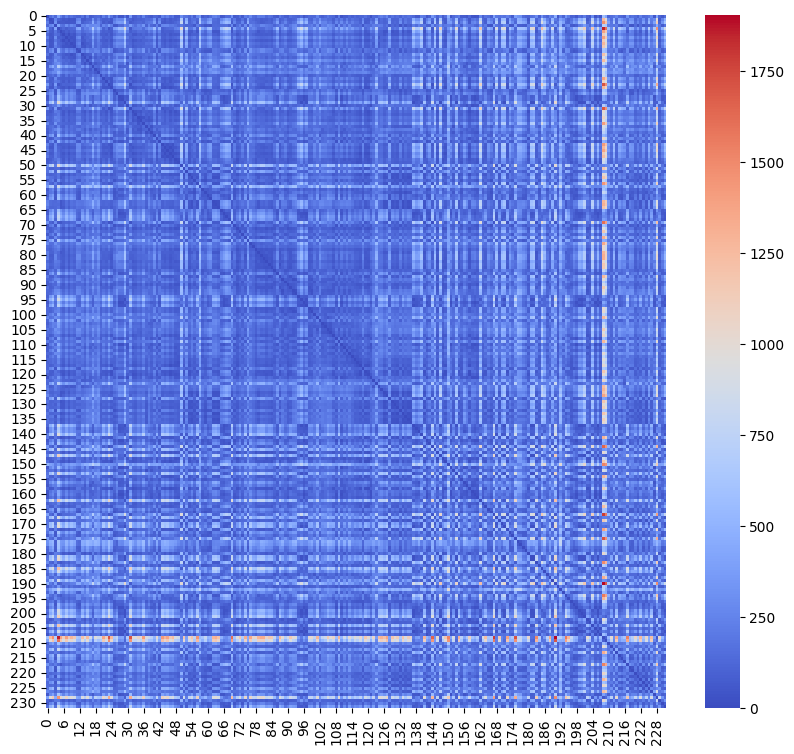

In [58]:
plt.figure(figsize=(10, 9))
#plt.axis('off')
heatmap = sns.heatmap(m, cmap=cmap)
#plt.savefig('image_filename.png', bbox_inches='tight')
plt.show()
plt.close()

232
46
230


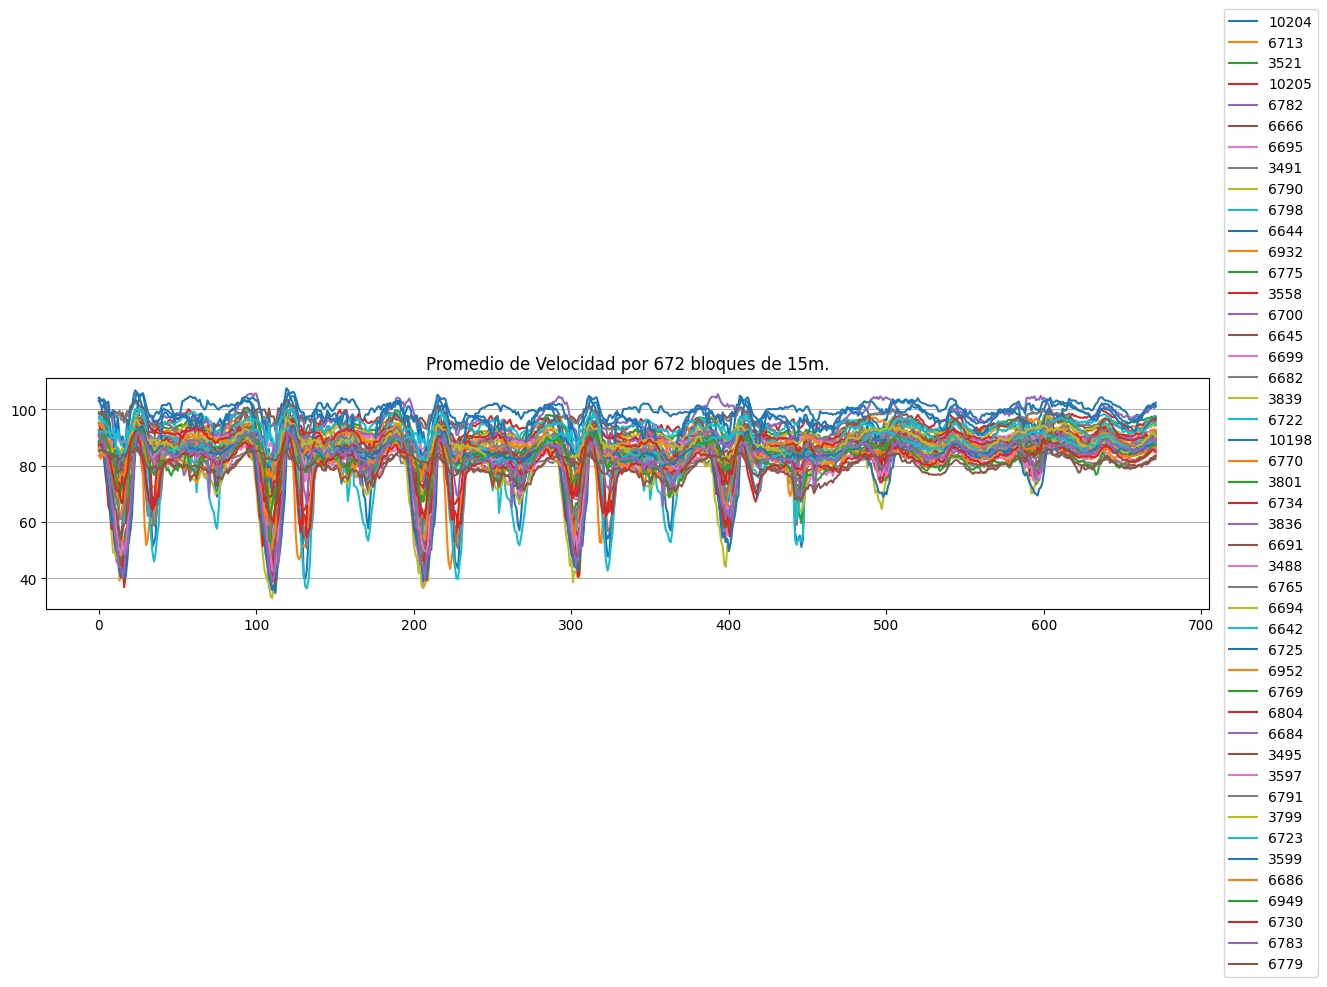

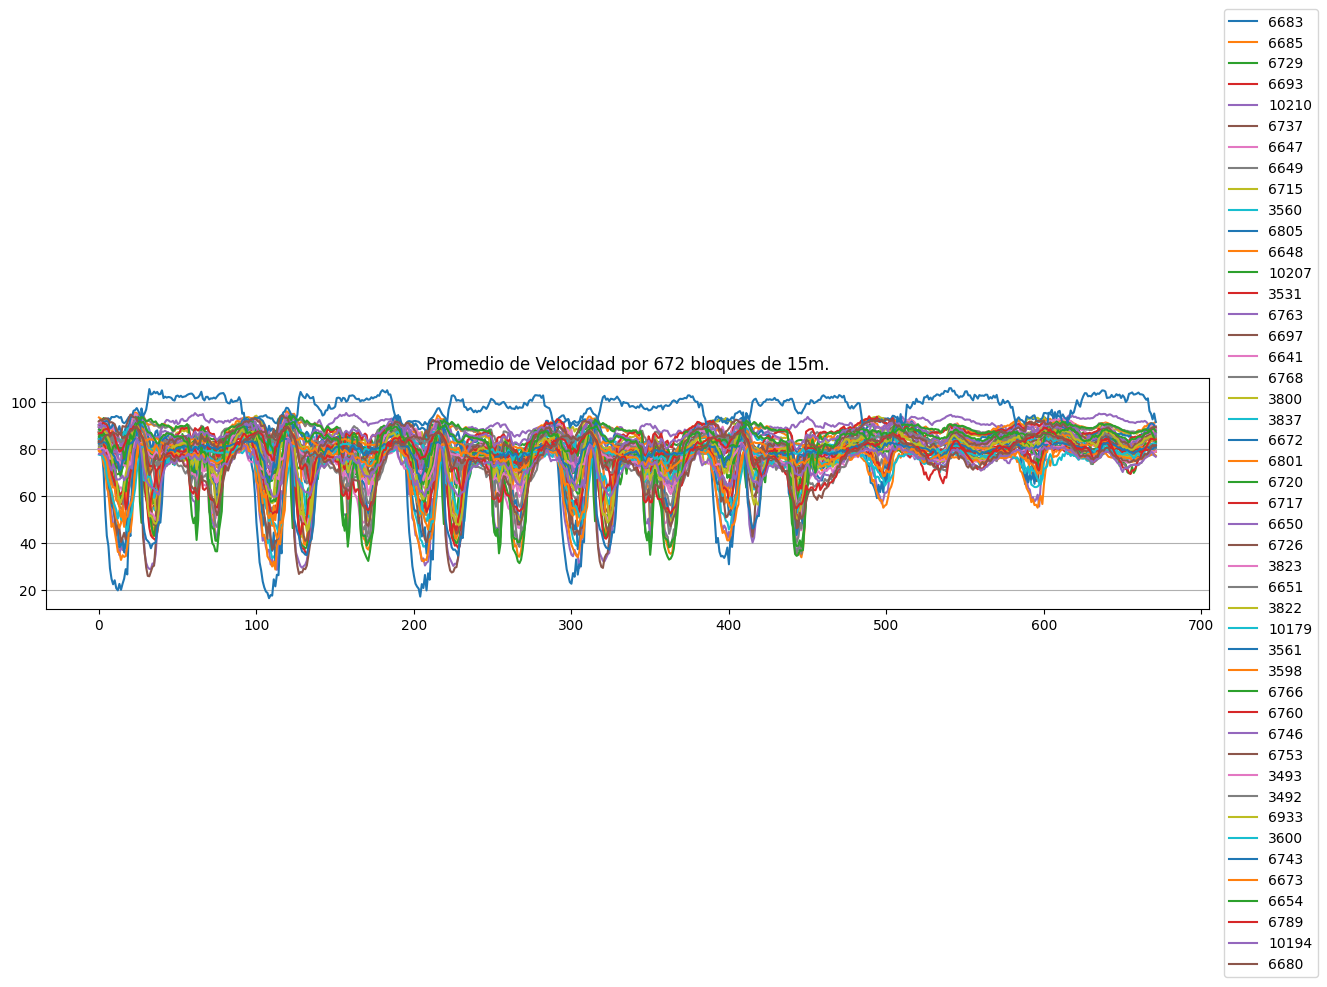

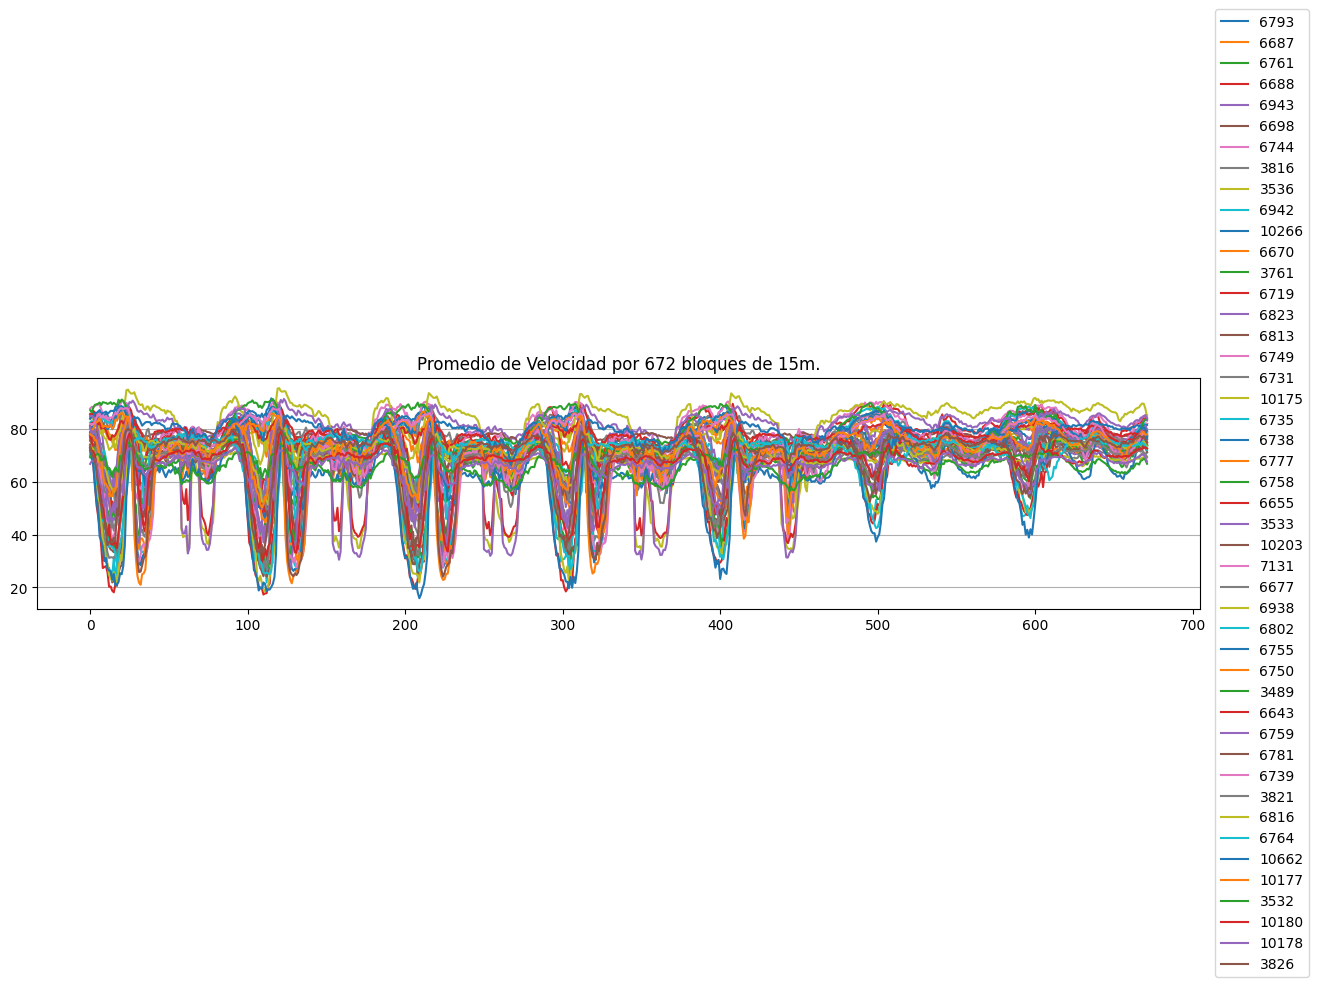

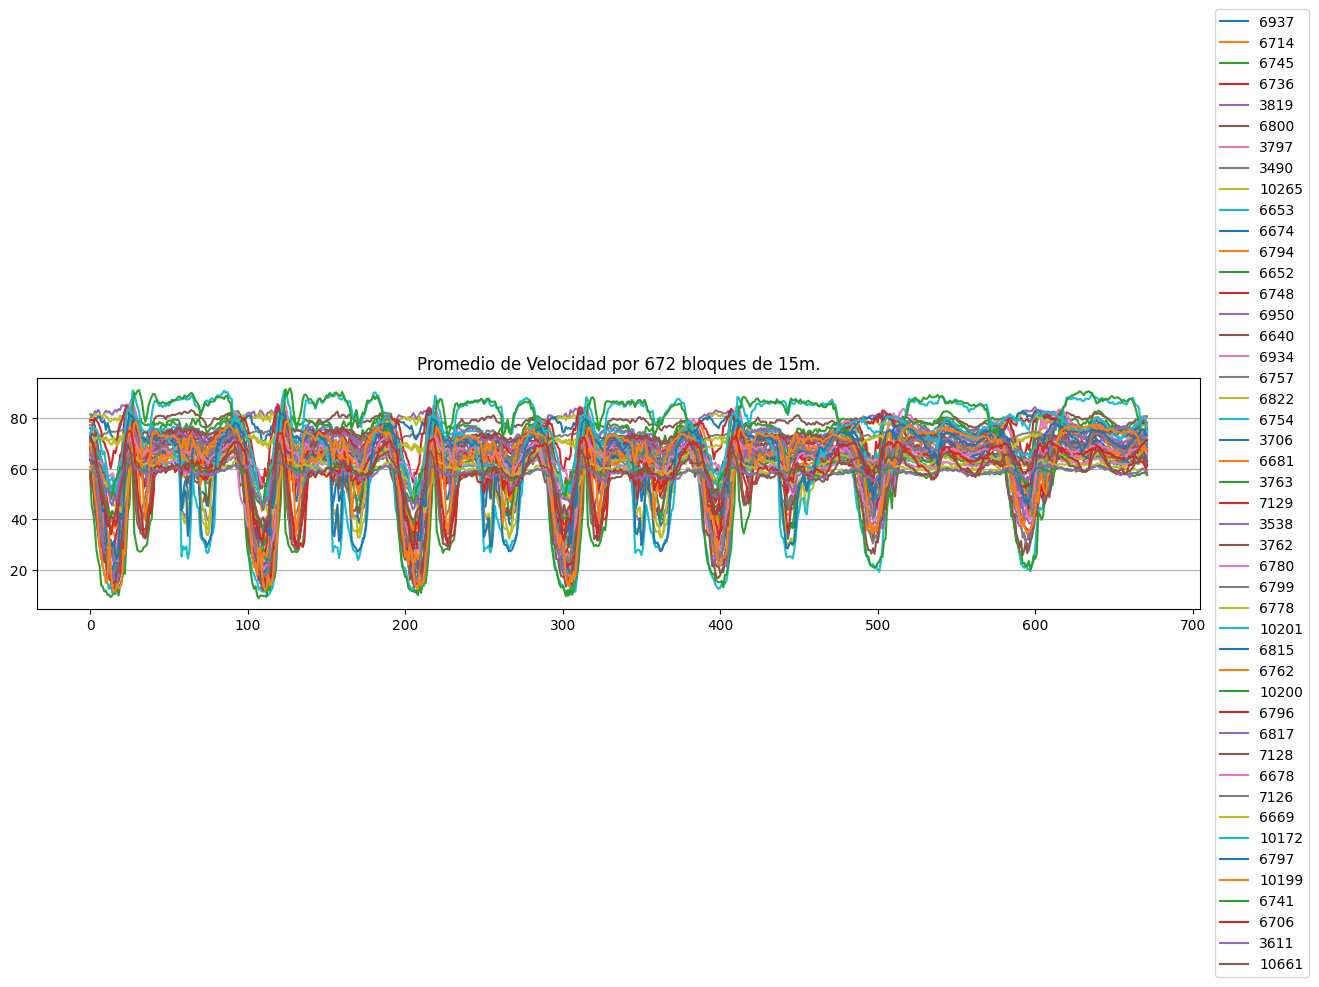

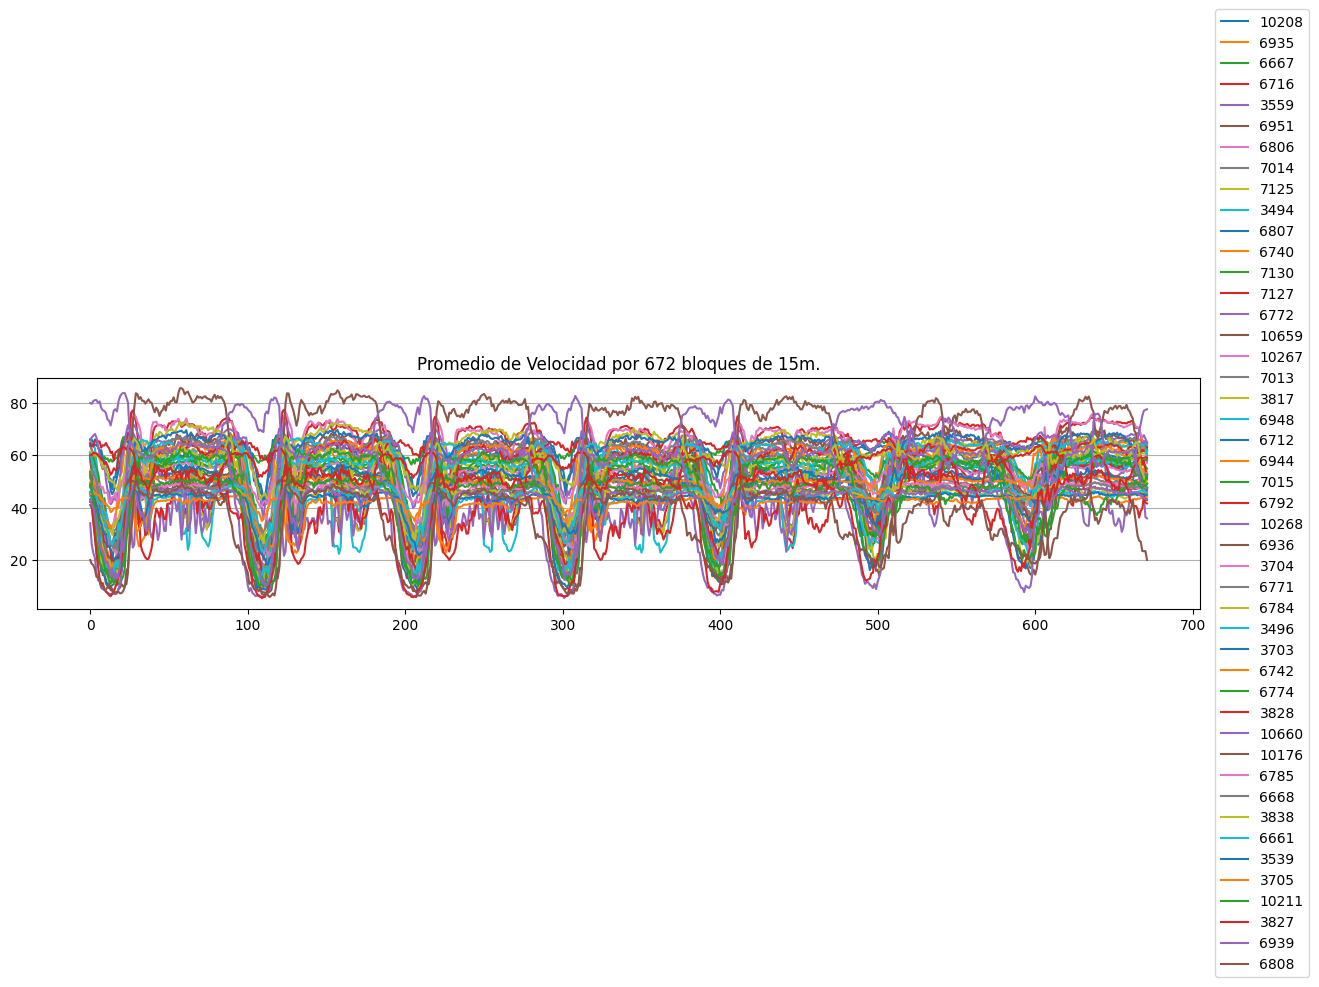

Archivo outputdata_m30_fulldates/m30_2024_ids_por_grupo_velocidad.txt escrito correctamente.


In [59]:
g1 = []
g2 = []
g3 = []
g4 = []
g5 = []
lgrupos = [g1, g2, g3, g4, g5]
ids_por_grupo = int(len(list_IDs_final) / 5)
print(len(list_IDs_final))
print(ids_por_grupo)
xesimo = 0
for g in lgrupos:
    # Buscar el xesimo elemento
    for x in range(ids_por_grupo):
        buscado = distF[xesimo]
        i = 0
        encontrado = False
        while i < len(list_IDs_final) and not encontrado:
            if m[fmax][i] == buscado:
                g.append(list_IDs_final[i])
                encontrado = True
            i += 1
        xesimo +=1
print(xesimo)
for g in lgrupos:
    graficaPromedioBloquesPorSerie(g, ids_por_grupo, 672)


# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_por_grupo_velocidad.txt"
archivo = open(nombrearchivo,"w")
for ids in lgrupos:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in lgrupos:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

In [60]:
posG = 1
temporalListCodes = []
for g in lgrupos:
    temporalCodes = []
    for i in g:
        if i in dicc_IdCod:
            temporalCodes.append(dicc_IdCod[i])
    temporalCodes.sort()
    temporalListCodes.append(temporalCodes)
print("Grupo 1\tGrupo 2\tGrupo 3\tGrupo 4\tGrupo 5")
for i in range(ids_por_grupo):
    for l in temporalListCodes:
        print(l[i], end="\t")
    print("")

# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_velocidad_por_grupos.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in lgrupos:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in lgrupos:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Grupo 1	Grupo 2	Grupo 3	Grupo 4	Grupo 5
PM10091	PM10021	PM10092	PM10013	PM10486	
PM10141	PM10212	PM10402	PM10343	PM10768	
PM10142	PM10241	PM10471	PM10344	PM12067	
PM10611	PM10242	PM10578	PM10472	PM12122	
PM10711	PM10341	PM10728	PM10502	PM12397	
PM10712	PM10342	PM10764	PM10533	PM13212	
PM10861	PM10401	PM10901	PM10765	PM13221	
PM11108	PM10612	PM10902	PM10766	PM13222	
PM11168	PM10862	PM10982	PM10832	PM20152	
PM11208	PM10865	PM11301	PM10945	PM20756	
PM12121	PM10941	PM11303	PM10985	PM20776	
PM12331	PM10942	PM12342	PM11102	PM20778	
PM12391	PM11101	PM12502	PM12572	PM22082	
PM12641	PM11161	PM12571	PM12622	PM22392	
PM12721	PM11201	PM20025	PM13041	PM22901	
PM12781	PM12241	PM20233	PM20042	PM22971	
PM20021	PM20026	PM20473	PM20596	PM23011	
PM20321	PM20041	PM20662	PM20664	PM23073	
PM20322	PM20151	PM20722	PM20777	PM23222	
PM20411	PM20231	PM20742	PM20834	PM30002	
PM20472	PM20261	PM20832	PM20854	PM30462	
PM20661	PM20412	PM20873	PM20864	PM30754	
PM21301	PM20471	PM20911	PM20972	PM30902	
PM22341	PM20667	P

80.50899
67.41186
70.57225
69.81731
99.60298
46.15465
96.69632
93.71743
48.44973
61.25103
84.28113
72.63565
0.0
60.76898
77.86381
10204
PM40951


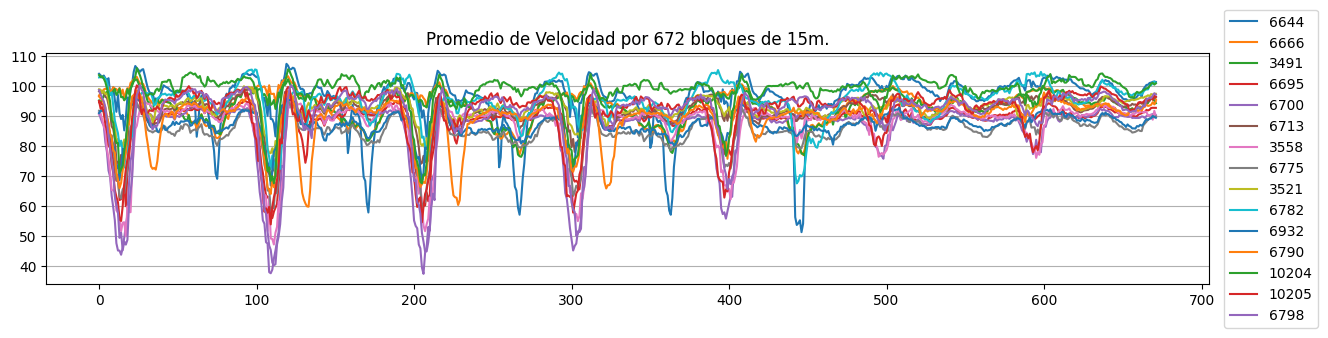

In [61]:
listatemporalIDs = []
for f in range(len(m[fmax])):
    if m[fmax][f] < 100:
        print(m[fmax][f])
        listatemporalIDs.append(list_IDs_final[f])
idfmax = list_IDs_final[fmax]
print(idfmax)
codfmax = dicc_IdCod[idfmax]
print(codfmax)
graficaPromedioBloquesPorSerie(listatemporalIDs, len(listatemporalIDs), 672)

In [62]:
def graficaPromedioBloquesPorSerieEnGrande(listaIDs, numSeriesGrafica, numBloquesGrafica):
    if len(listaIDs) < numSeriesGrafica:
        numSeriesGrafica = len(listaIDs)
    promedio_horas = []
    for ids in listaIDs[:numSeriesGrafica]:
        ph = np.zeros(numBloquesGrafica)
        ps = dicc_posID[ids]
        for p in range(numFechas):
            ph[p%numBloquesGrafica] += grillaVelocidad[ps][p]
        muestrasXhora = numFechas/numBloquesGrafica
        for p in range(numBloquesGrafica):
            ph[p] = ph[p] / muestrasXhora
        promedio_horas.append(ph)
    plt.figure(figsize=(16,7))
    for s in range(numSeriesGrafica):
        plt.plot(promedio_horas[s], label=str(listaIDs[s])+" ["+dicc_IdCod[listaIDs[s]]+"]")
    plt.title('Promedio de Velocidad por '+str(numBloquesGrafica)+' bloques de 15m.')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    ticks = range(numBloquesGrafica)
    #plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.show()
    plt.close()

In [63]:
# Estrategia: utilizar una serie de referencia y un factor que permita reducir los valores
def estrategiaSerieReferenciaYFactor(listaIDs, listaReferencia):
    if len(listaReferencia) != numFechas:
        print("Error! la lista de referencia no es del largo " + str(numFechas))
    diccHistoDO = {}
    diccHistoPR = {}
    factores = []
    for i in listaIDs:
        ps = dicc_posID[i]
        factor = int(sum(grillaVelocidad[ps]) / sum(listaReferencia))
        factores.append(factor)
        for x in range(numFechas):
            vDO = grillaVelocidad[ps][x]
            if vDO not in diccHistoDO:
                diccHistoDO[vDO] = 1
            else:
                diccHistoDO[vDO] += 1
            vPR = vDO - (factor * listaReferencia[x])
            if vPR not in diccHistoPR:
                diccHistoPR[vPR] = 1
            else:
                diccHistoPR[vPR] += 1
    listadoDicc = [diccHistoDO, diccHistoPR]
    listadoTitu = ["Datos Originales", "Propuesta Prom + Factor (Velocidad)"]
    tit = "Histograma Comparación para Datos Originales vs Promedio + Factor (Intensidad)"
    plotHistograma(listadoDicc, listadoTitu, tit)
    print("Factores:", factores)

Valores minimos: [np.int64(0), np.int64(-135)]
Valores máximos: [np.int64(198), np.int64(107)]


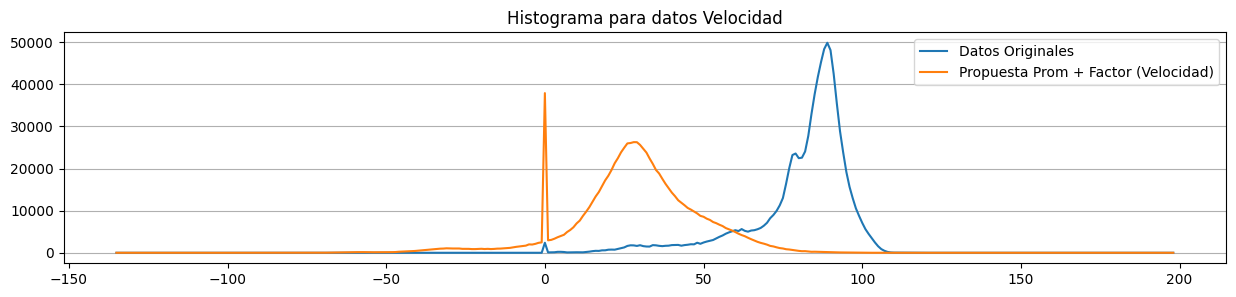

Factores: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Valores minimos: [np.int64(0), np.int64(-65)]
Valores máximos: [np.int64(111), np.int64(99)]


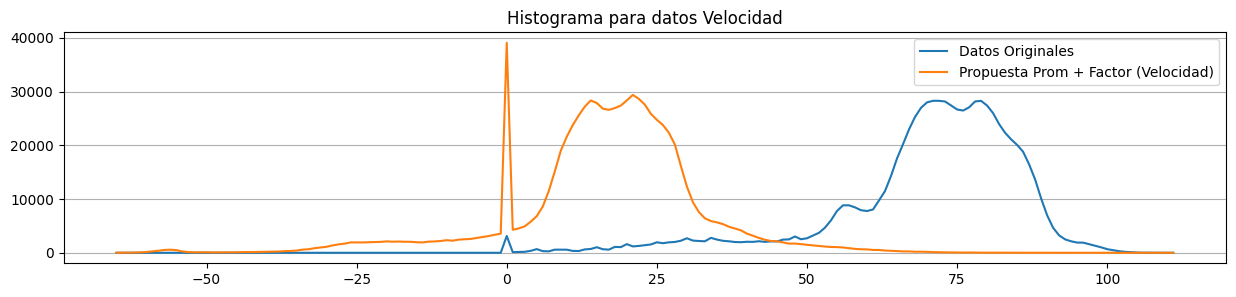

Factores: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Valores minimos: [np.int64(0), np.int64(-64)]
Valores máximos: [np.int64(118), np.int64(101)]


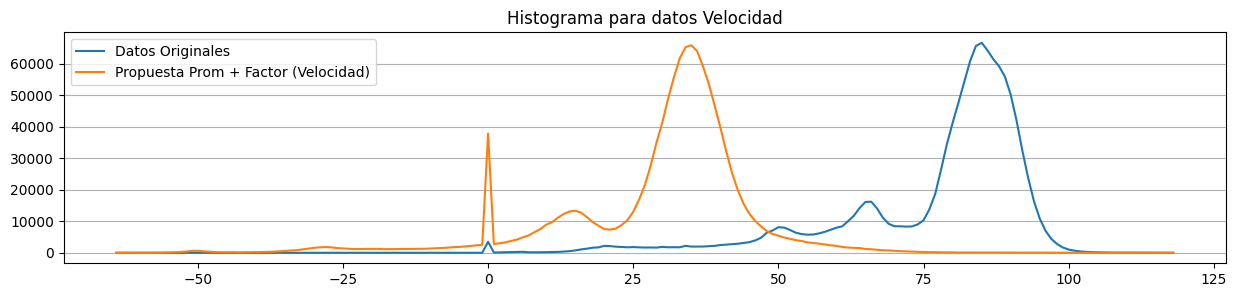

Factores: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Valores minimos: [np.int64(0), np.int64(-72)]
Valores máximos: [np.int64(120), np.int64(98)]


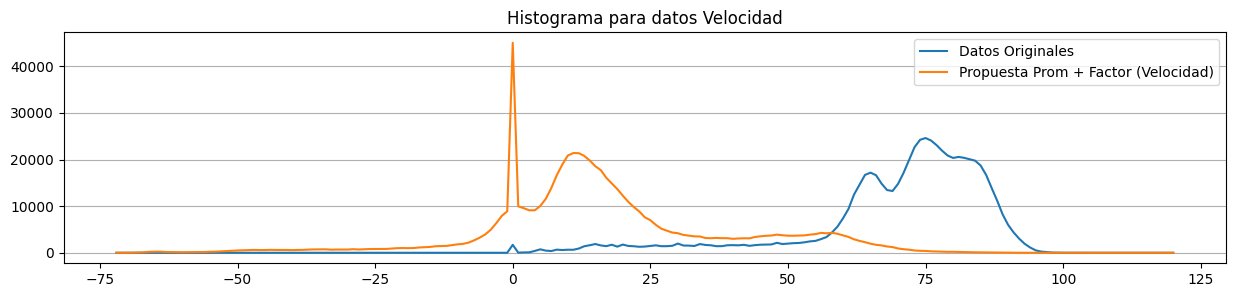

Factores: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Valores minimos: [np.int64(0), np.int64(-123)]
Valores máximos: [np.int64(235), np.int64(202)]


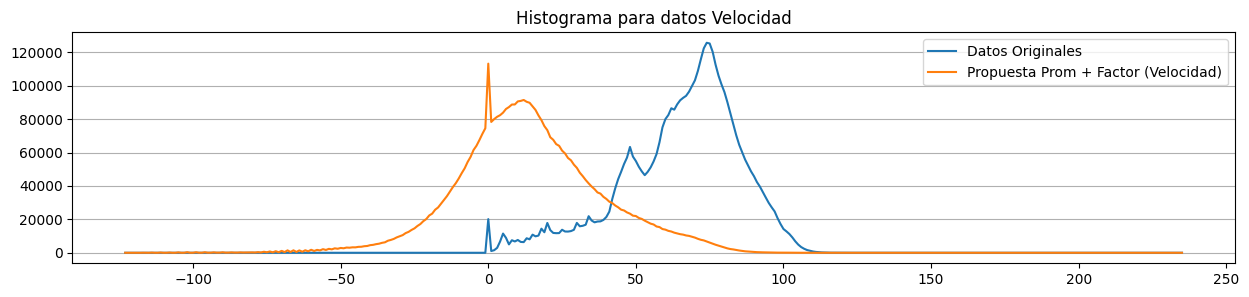

Factores: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 3, 1, 2, 3, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 2, 1, 2, 3, 2, 2, 3, 1, 3, 1, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 2, 1, 1, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 3, 2, 1]


In [64]:
# Usando como referencia la lista con la menor suma de valores
for listaIDs in ids_PM_full:
    idMenor = listaIDs[0]
    ps = dicc_posID[idMenor]
    sumMenor = sum(grillaVelocidad[ps])
    for ide in listaIDs:
        ps = dicc_posID[ide]
        s = sum(grillaVelocidad[ps])
        if s < sumMenor :
            sumMenor = s
            idMenor = ide
    ps = dicc_posID[idMenor]
    estrategiaSerieReferenciaYFactor(listaIDs, grillaVelocidad[ps])

3.20051 181 182 10176 6661


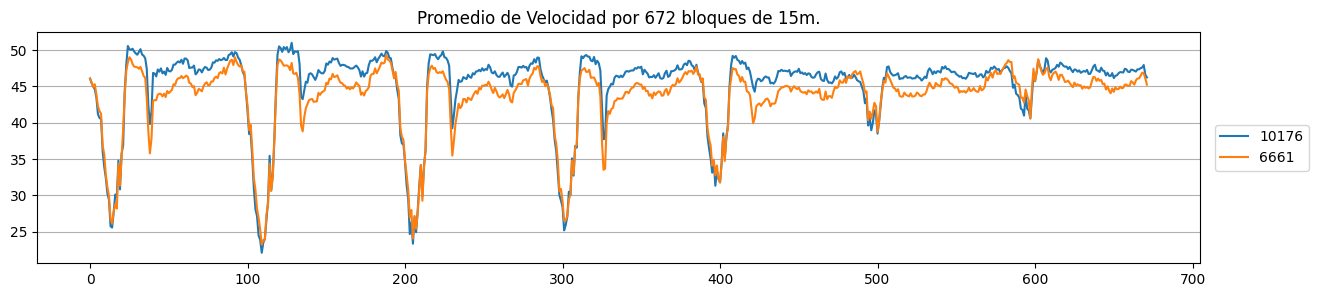

[ 0.       3.20051 15.13608 17.35485 19.735   21.8269 ]
Primeros 10
Buscando: 0.0
Encontrado en pos: 181 correspondiente a ID: 10176 con código: PM40462
Buscando: 3.20051
Encontrado en pos: 182 correspondiente a ID: 6661 con código: PM40463
Buscando: 15.13608
Encontrado en pos: 29 correspondiente a ID: 6668 con código: PM10768
Buscando: 17.35485
Encontrado en pos: 137 correspondiente a ID: 6771 con código: PM22901
Buscando: 19.735
Encontrado en pos: 206 correspondiente a ID: 6936 con código: PM41802
Buscando: 21.8269
Encontrado en pos: 147 correspondiente a ID: 3539 con código: PM30462
Buscando: 22.46972
Encontrado en pos: 153 correspondiente a ID: 3838 con código: PM30902
Buscando: 23.14735
Encontrado en pos: 95 correspondiente a ID: 6742 con código: PM20776
Buscando: 24.96193
Encontrado en pos: 171 correspondiente a ID: 6785 con código: PM33151
Buscando: 25.92256
Encontrado en pos: 199 correspondiente a ID: 3703 con código: PM41302
10176	6661	6668	6771	6936	3539	3838	6742	6785	3703	


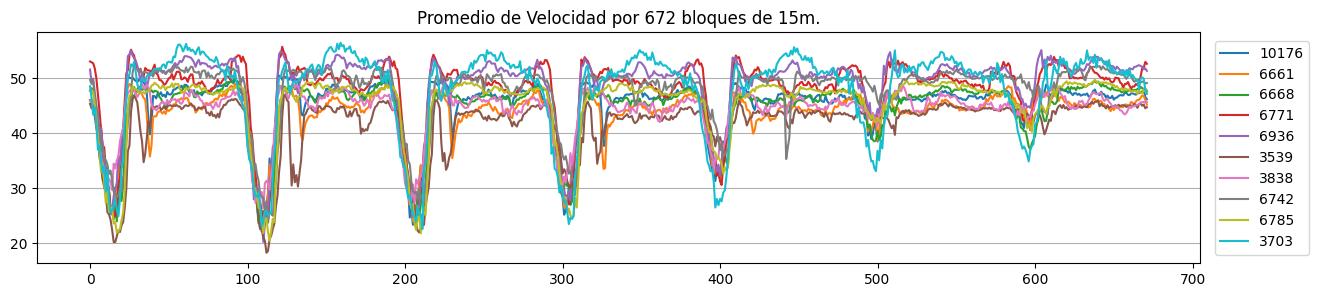

Ultimos 10
Buscando: 1014.96164
Encontrado en pos: 190 correspondiente a ID: 10204 con código: PM40951
Buscando: 970.70153
Encontrado en pos: 4 correspondiente a ID: 6644 con código: PM10141
Buscando: 923.11953
Encontrado en pos: 167 correspondiente a ID: 6782 con código: PM32351
Buscando: 890.23378
Encontrado en pos: 175 correspondiente a ID: 10198 con código: PM40011
Buscando: 864.91578
Encontrado en pos: 23 correspondiente a ID: 6666 con código: PM10711
Buscando: 856.41817
Encontrado en pos: 31 correspondiente a ID: 3491 con código: PM10861
Buscando: 840.37805
Encontrado en pos: 150 correspondiente a ID: 3561 con código: PM30753
Buscando: 829.07949
Encontrado en pos: 144 correspondiente a ID: 3521 con código: PM30001
Buscando: 789.98573
Encontrado en pos: 69 correspondiente a ID: 6713 con código: PM20021
Buscando: 779.74708
Encontrado en pos: 194 correspondiente a ID: 10205 con código: PM41201
10204	6644	6782	10198	6666	3491	3561	3521	6713	10205	


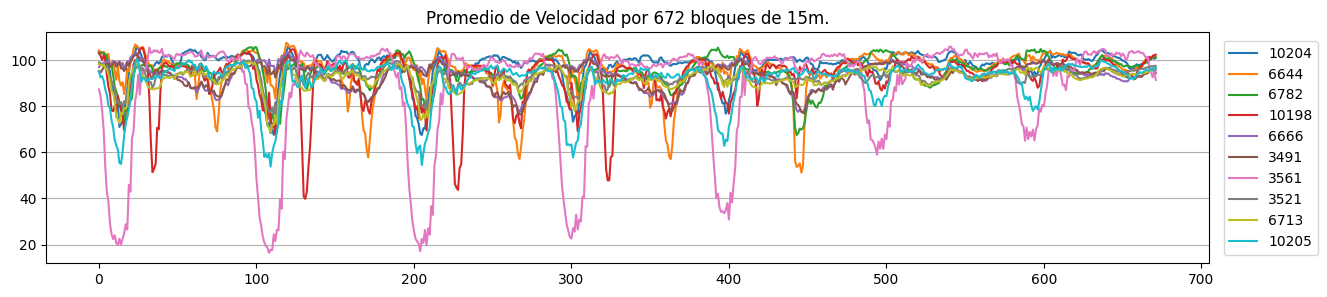

In [65]:
minmatriz = m[0][1]
fmin = [0]
cmin = [1]
for f in range(len(m)):
    for c in range(len(m[f])):
        if m[f][c] < minmatriz and m[f][c] != 0:
            minmatriz = m[f][c]
            fmin = f
            cmin = c
print(minmatriz, fmin, cmin, list_IDs_final[fmin], list_IDs_final[cmin])
graficaPromedioBloquesPorSerie([list_IDs_final[fmin], list_IDs_final[cmin]], 2, 672)
filaMenor = m[fmin].copy()
filaMenor.sort()
print(filaMenor[:6])
print("Primeros 10")
listaIDsMasParecidos = []
for i in range(10):
    busca = filaMenor[i]
    print("Buscando:", busca)
    j = 0
    while j<len(m) and m[fmin][j] != busca:
        j+= 1
    print("Encontrado en pos:", j, "correspondiente a ID:", list_IDs_final[j], "con código:", dicc_IdCod[list_IDs_final[j]])
    listaIDsMasParecidos.append(int(list_IDs_final[j]))
for i in listaIDsMasParecidos:
    print(i, end="\t")
print("")
graficaPromedioBloquesPorSerie(listaIDsMasParecidos, len(listaIDsMasParecidos), 672)
print("Ultimos 10")
listaIDsMasParecidos = []
for i in range(10):
    busca = filaMenor[len(list_IDs_final) - i - 1]
    print("Buscando:", busca)
    j = 0
    while j<len(m) and m[fmin][j] != busca:
        j+= 1
    print("Encontrado en pos:", j, "correspondiente a ID:", list_IDs_final[j], "con código:", dicc_IdCod[list_IDs_final[j]])
    listaIDsMasParecidos.append(int(list_IDs_final[j]))
for i in listaIDsMasParecidos:
    print(i, end="\t")
print("")
graficaPromedioBloquesPorSerie(listaIDsMasParecidos, len(listaIDsMasParecidos), 672)

In [68]:
# Calculando listas de vecindad por distancia
from geopy import distance

In [69]:
# Versión: vecinos por distancia menor a umbral
dist0050 = []
dist0100 = []
dist0150 = []
dist0250 = []
dist0500 = []
dist0750 = []
dist1000 = []
print("Calculando vecinos con distintas distancias")
matrizDistanciasKm = np.zeros((cantSensFinal,cantSensFinal))
for x in range(0,cantSensFinal):
    idx = list_IDs_final[x]
    cooX = (dicc_IdLatLon[idx][0][0], dicc_IdLatLon[idx][0][1])
    temDist0050 = 0
    temDist0100 = 0
    temDist0150 = 0
    temDist0250 = 0
    temDist0500 = 0
    temDist0750 = 0
    temDist1000 = 0
    for y in range(0,cantSensFinal):
        if x != y:
            idy = list_IDs_final[y]
            cooY = (dicc_IdLatLon[idy][0][0], dicc_IdLatLon[idy][0][1])
            dKm = distance.distance(cooX, cooY).km
            matrizDistanciasKm[x][y] = dKm
            if dKm <= 1 :
                temDist1000 += 1
            if dKm <= 0.75:
                temDist0750 += 1
            if dKm <= 0.5:
                temDist0500 += 1
            if dKm <= 0.25:
                temDist0250 += 1
            if dKm <= 0.15:
                temDist0150 += 1
            if dKm <= 0.1:
                temDist0100 += 1
            if dKm <= 0.05:
                temDist0050 += 1
        else:
            matrizDistanciasKm[x][y] = 0.0
    dist0050.append(temDist0050)
    dist0100.append(temDist0100)
    dist0150.append(temDist0150)
    dist0250.append(temDist0250)
    dist0500.append(temDist0500)
    dist0750.append(temDist0750)
    dist1000.append(temDist1000)
print("Listo")

Calculando vecinos con distintas distancias
Listo


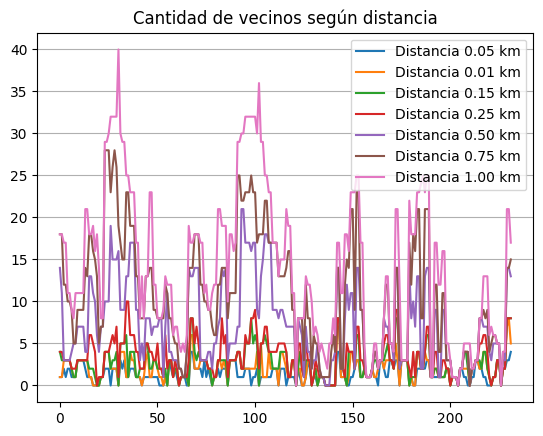

In [70]:
plt.plot(dist0050, label='Distancia 0.05 km')
plt.plot(dist0100, label='Distancia 0.01 km')
plt.plot(dist0150, label='Distancia 0.15 km')
plt.plot(dist0250, label='Distancia 0.25 km')
plt.plot(dist0500, label='Distancia 0.50 km')
plt.plot(dist0750, label='Distancia 0.75 km')
plt.plot(dist1000, label='Distancia 1.00 km')
plt.title("Cantidad de vecinos según distancia")
#plt.savefig('images/histograma_vecinos_x_distncia.png', bbox_inches='tight')
plt.grid(axis='y')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

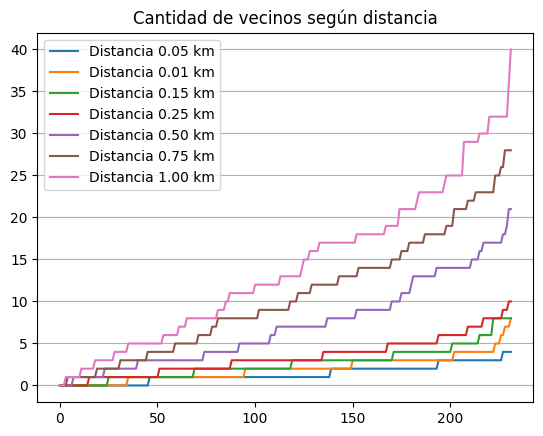

In [71]:
dist0050.sort()
dist0100.sort()
dist0150.sort()
dist0250.sort()
dist0500.sort()
dist0750.sort()
dist1000.sort()
plt.plot(dist0050, label='Distancia 0.05 km')
plt.plot(dist0100, label='Distancia 0.01 km')
plt.plot(dist0150, label='Distancia 0.15 km')
plt.plot(dist0250, label='Distancia 0.25 km')
plt.plot(dist0500, label='Distancia 0.50 km')
plt.plot(dist0750, label='Distancia 0.75 km')
plt.plot(dist1000, label='Distancia 1.00 km')
plt.title("Cantidad de vecinos según distancia")
#plt.savefig('images/histograma_vecinos_x_distncia.png', bbox_inches='tight')
plt.grid(axis='y')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [72]:
print(matrizDistanciasKm)
print("Generando diccionario con vecinos de 50, 100, 150 y 250 metros.")
dicc_vec_dist_0050 = {}
dicc_vec_dist_0100 = {}
dicc_vec_dist_0150 = {}
dicc_vec_dist_0250 = {}
for x in range(0,cantSensFinal):
    temVec0050 = []
    temVec0100 = []
    temVec0150 = []
    temVec0250 = []
    for y in range(0,cantSensFinal):
        if x != y:
            if matrizDistanciasKm[x][y] <= 0.05:
                temVec0050.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.1:
                temVec0100.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.15:
                temVec0150.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.25:
                temVec0250.append(list_IDs_final[y])
    if len(temVec0050) > 0:
        dicc_vec_dist_0050[list_IDs_final[x]] = temVec0050
    if len(temVec0100) > 0:
        dicc_vec_dist_0100[list_IDs_final[x]] = temVec0100
    if len(temVec0150) > 0:
        dicc_vec_dist_0150[list_IDs_final[x]] = temVec0150
    if len(temVec0250) > 0:
        dicc_vec_dist_0250[list_IDs_final[x]] = temVec0250

# Comprobando coincidencia en el largo de la lista de vecinos
for i in range(5):
    tempID = list_IDs_final[i]
    print("Elemento", i, "con id:", tempID)
    print("050m:", dist0050[i], len(dicc_vec_dist_0050[tempID]), dicc_vec_dist_0050[tempID])
    print("100m:", dist0100[i], len(dicc_vec_dist_0100[tempID]), dicc_vec_dist_0100[tempID])
    print("150m:", dist0150[i], len(dicc_vec_dist_0150[tempID]), dicc_vec_dist_0150[tempID])
    print("250m:", dist0250[i], len(dicc_vec_dist_0250[tempID]), dicc_vec_dist_0250[tempID])

[[0.         0.03509579 0.55316363 ... 0.38901137 0.39507263 0.48652983]
 [0.03509579 0.         0.51866324 ... 0.41843075 0.4246481  0.51684383]
 [0.55316363 0.51866324 0.         ... 0.92189073 0.92861506 1.02226484]
 ...
 [0.38901137 0.41843075 0.92189073 ... 0.         0.00698894 0.10039282]
 [0.39507263 0.4246481  0.92861506 ... 0.00698894 0.         0.0936498 ]
 [0.48652983 0.51684383 1.02226484 ... 0.10039282 0.0936498  0.        ]]
Generando diccionario con vecinos de 50, 100, 150 y 250 metros.
Elemento 0 con id: 6640
050m: 0 1 [np.int64(6641)]
100m: 0 1 [np.int64(6641)]
150m: 0 4 [np.int64(6641), np.int64(6713), np.int64(3821), np.int64(3822)]
250m: 0 4 [np.int64(6641), np.int64(6713), np.int64(3821), np.int64(3822)]
Elemento 1 con id: 6641
050m: 0 1 [np.int64(6640)]
100m: 0 1 [np.int64(6640)]
150m: 0 3 [np.int64(6640), np.int64(6713), np.int64(3822)]
250m: 0 4 [np.int64(6640), np.int64(6713), np.int64(3821), np.int64(3822)]
Elemento 2 con id: 6642
050m: 0 2 [np.int64(6643), n

In [73]:
print(len(dicc_vec_dist_0050))
print(len(dicc_vec_dist_0100))
print(len(dicc_vec_dist_0150))
print(len(dicc_vec_dist_0250))

186
197
207
217


In [74]:
exportarArchivoVecinos(dicc_vec_dist_0050, "outputdata_m30_fulldates/m30_2024_listavecinos_050m_velocidad.txt")
exportarArchivoVecinos(dicc_vec_dist_0100, "outputdata_m30_fulldates/m30_2024_listavecinos_100m_velocidad.txt")
exportarArchivoVecinos(dicc_vec_dist_0150, "outputdata_m30_fulldates/m30_2024_listavecinos_150m_velocidad.txt")
exportarArchivoVecinos(dicc_vec_dist_0250, "outputdata_m30_fulldates/m30_2024_listavecinos_250m_velocidad.txt")

Archivo outputdata_m30_fulldates/m30_2024_listavecinos_050m_velocidad.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_100m_velocidad.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_150m_velocidad.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_250m_velocidad.txt escrito correctamente.


In [75]:
# Generando lista de vecinos donde cada sensor se relaciona con los 2 más cercanos a él.
dicc2vecinosmasproximos = {}
for x in range(cantSensFinal):
    idX = list_IDs_final[x]
    dosmascerca = []
    for y in range(cantSensFinal):
        dxy = matrizDistanciasKm[x][y]
        if dxy > 0:
            if len(dosmascerca) < 2:
                dosmascerca.append(dxy)
            else:
                if dxy < max(dosmascerca):
                    dosmascerca = [min(dosmascerca),dxy]
    idsvecinostemp = []
    for y in range(cantSensFinal):
        if matrizDistanciasKm[x][y] == dosmascerca[0] or matrizDistanciasKm[x][y] == dosmascerca[1]:
            idsvecinostemp.append(int(list_IDs_final[y]))
    dicc2vecinosmasproximos[idX] = idsvecinostemp
    if len(idsvecinostemp) > 2:
        print("Warning! lista con", len(idsvecinostemp), "elementos.")
print("Sensores con los 2 vecinos más cerca:", len(dicc2vecinosmasproximos))
exportarArchivoVecinos(dicc2vecinosmasproximos, "outputdata_m30_fulldates/m30_2024_listavecinos_2masproximos_velocidad.txt")

Sensores con los 2 vecinos más cerca: 232
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_2masproximos_velocidad.txt escrito correctamente.
